В ходе учебной практики в компании Webgames мной решалась задача предсказания LTV (lifetime value, пожизненной стоимости клиента) на основе предоставленных пользовательских данных приложения для iOS. Расчёт данной метрики для пользователя позволяет предсказать, какую прибыль от него следует ожидать, и соответствующим способом модифицировать возможные предложения по скидкам для внутриигровых покупок. Использовались файлы со следующими данными:


```practice_dau_and``` - ежедневные сообщения с устройства игрока
* id - идентификатор игрока;
* сountry - страна;
* number_of_pgr - количество PGR-сообщений (их шлет устройство во время игры);
* actdate - дата события.

```practice_pact_and``` - агрегированные данные о деятельности игрока в этот день
* id - идентификатор игрока;
* actdate - дата события;
* regdate - дата регистрации игрока;
* clusters_ml_ended - сколько кластеров (кластеры состоят из квестов) основной сюжетной линии прошел игрок;
* revenue - прибыль с игрока;
* transactions - количество платежей;
* quests_end - сколько побочных квестов прошел игрок;
* m_quests_end - сколько квестов основной сюжетной линии прошел игрок;
* crystals_value_spend - сколько кристаллов (в определенной нормировке) потратил игрок;
* store_enters - сколько раз игрок зашел в магазин.

Для оценки моделей использовались следующие метрики:
* RMSE — Root Mean Squared Error
* MAE — Mean Absolute Error

Также качество предсказания справнивалось следующим образом: из всей выборки выделялась в тестовую информация по пользователям, зарегистрировавшимся с 13 по 19 февраля 2017 года (данные по игрокам, зарегистрировавшимся до этого, соответственно, являлись обучающей выборкой), затем все предсказания модели по каждому из пользователей и дней недели суммировались и сравнивались с действительными показателями.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
from itertools import product
from sklearn.preprocessing import LabelEncoder
from datetime import timedelta
import gc
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor, early_stopping
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
import lightgbm
import sklearn
from multiprocessing import Pool, cpu_count
from functools import partial
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['savefig.dpi'] = 400

Для начала загрузим данные и удалим строки-дубликаты из таблицы ```practice_dau_and``` (из двух записей о пользователе в один и тот же день выбиралась запись с большим числом PGR-сообщений), а также удалили из таблицы ```practice_pact_and``` столбцы ```crystals_value_spend``` и ```store_enters```, так как они содержат только 0 и изменили дату регистрации для каждого пользователя на наиболее раннюю. Для уменьшения занимаемой памяти категориальные признаки ```country``` и ```id``` преобразовывались в целочисленные с помощью ```LabelEncoder```.

In [3]:
dau=pd.read_csv("practice_dau_ios.csv",sep="|",header=None,engine="c",names=["id","country","number_of_pgr","actdate"],
                dtype={"number_of_pgr":"int16"},
                parse_dates=[3],na_filter=False).sort_values(by=["id","actdate","number_of_pgr"]).drop_duplicates(
    subset=["id","actdate"],keep="last")
pact=pd.read_csv("practice_pact_ios.csv",sep="|",header=None,engine="c",names=
                ["id","actdate","regdate","clusters_ml_ended","revenue","transactions","quests_end","m_quests_end",
                "crystals_value_spend","store_enters"],usecols=["id","actdate","regdate","clusters_ml_ended",
                "revenue","transactions","quests_end","m_quests_end"],dtype={"clusters_ml_ended":"int8",
                "revenue":"float32","transactions":"int8","quests_end":"int16","m_quests_end":"int16"},
                 parse_dates=[1,2])
pact=pact.drop("regdate",axis=1).join(pact.groupby("id").regdate.min().to_frame(),on="id")
pact=pd.merge(dau,pact,on=["id","actdate"],copy=False)
lenc_cntr=LabelEncoder()
lenc_id=LabelEncoder()
pact.country=lenc_cntr.fit_transform(pact.country.values).astype("uint8")
pact.id=lenc_cntr.fit_transform(pact.id.values).astype("uint32")
del dau

Всё преобразование данных для деления на обучающую и тестовую выборки в вид, в котором одному пользователю сопоставляется вектор признаков
описано в функции split_data:
    
* ```pact``` — исходная таблица с объединёнными данными из двух источников, прошедшими предварительную очистку
* ```days_obs``` — число дней, по наблюдению за которые проводились предсказания
* ```days_pred``` — число дней, по наблюдению за которые рассчитывалась прибыль с пользователя
* ```threshold``` — порог, по превышению которого прибыль (как за конкретный день, так и по окончанию периода наблюдений) становилась равной ```threshold```


In [20]:
def split_data(pact,days_obs,days_pred,testweek=False,threshold=1000,extra_features=False):
    y=pact[(pact.actdate-pact.regdate)<=timedelta(days=days_pred-1)].groupby("id").revenue.sum().to_frame()
    y.loc[y.revenue>threshold,"revenue"]=threshold
    pact_train=pact[(pact.actdate-pact.regdate)<=timedelta(days=days_obs-1)].copy()
    pact_train.loc[pact_train.revenue>threshold,"revenue"]=threshold
    pact_train["day"]=((pact_train["actdate"]-pact_train["regdate"])/np.timedelta64(1, 'D')).astype("int8")
    pact_train=pact_train.set_index(["id","day"]).reindex(pd.MultiIndex.from_product([pact_train["id"].unique(), range(days_obs)], names=["id", "day"]))
    pact_train.regdate.fillna(method="ffill",inplace=True)
    pact_train.country.fillna(method="ffill",inplace=True)
    pact_train.actdate=pd.to_timedelta(pact_train.index.get_level_values(level=1),"d")+pact_train.regdate
    pact_train.fillna(0,inplace=True)
    pact_train["regmonth"]=pact_train.regdate.dt.month
    pact_train["regday"]=pact_train.regdate.dt.day
    pact_train["actmonth"]=pact_train.actdate.dt.month
    pact_train["actday"]=pact_train.actdate.dt.day
    pact_train=pact_train.drop(["regdate","actdate"],axis=1).unstack().drop(
        [col for col in product(["regmonth","regday","country"],range(1,days_obs))],axis=1)
    pact_train[[("country",0)]+[col for col in product(["transactions","actmonth","actday"],range(days_obs))]]=pact_train[[
    ("country",0)]+[col for col in product(["transactions","actmonth","actday"],range(days_obs))]].astype("uint8")
    pact_train[[col for col in product(["clusters_ml_ended"],range(days_obs))]]=pact_train[
        [col for col in product(["clusters_ml_ended"],range(days_obs))]].astype("int8")
    pact_train[[col for col in product(["revenue"],range(days_obs))]]=pact_train[
        [col for col in product(["revenue"],range(days_obs))]].astype("float32")
    pact_train[[col for col in product(["number_of_pgr","quests_end","m_quests_end"],range(days_obs))]]=pact_train[[
        col for col in product(["number_of_pgr","quests_end","m_quests_end"],range(days_obs))]].astype("int16")
    pact_train.columns=["".join(map(str,col)) for col in pact_train.columns]
    pact_train.rename(columns={"regmonth0":"regmonth","regday0":"regday","country0":"country"},inplace=True)
    pact_train.index.name=None
    if extra_features:
        pact_train["rev_min"]=np.min(pact_train[["revenue"+str(i) for i in range(days_obs)]],axis=1)
        pact_train["rev_max"]=np.max(pact_train[["revenue"+str(i) for i in range(days_obs)]],axis=1)
        pact_train["rev_mean"]=np.mean(pact_train[["revenue"+str(i) for i in range(days_obs)]],axis=1)
        pact_train["rev_median"]=np.median(pact_train[["revenue"+str(i) for i in range(days_obs)]],axis=1)
        pact_train["rev_std"]=np.std(pact_train[["revenue"+str(i) for i in range(days_obs)]],axis=1)
        pact_train["rev_nonzero"]=np.count_nonzero(pact_train[["revenue"+str(i) for i in range(days_obs)]],axis=1)
        pact_train["frac_zero"]=1-pact_train["rev_nonzero"]/days_obs
    cleaned=pd.merge(pact_train,y,left_index=True,right_index=True)
    if testweek:
        train=cleaned[(cleaned.regmonth==1)|((cleaned.regmonth==2)&(cleaned.regday<13))]
        test=[cleaned[(cleaned.regmonth==2)&(cleaned.regday==day)] for day in range(13,20)]
        return train,test
    else:
        train=cleaned[((cleaned.regmonth==4)&(cleaned.regday<11))|(cleaned.regmonth<=3)]
        test=cleaned[((cleaned.regmonth==4)&(cleaned.regday>=11))|(cleaned.regmonth>=5)]
        return train,test

В процессе сравнивались следующие модели: LightGBM, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, ElasticNetCV (линейная модель с L1- и L2-регуляризацией)

In [21]:
def fit(regr,X,y):
    return regr.fit(X,y)

def get_models_scores(pact,days_obs,days_pred):
    print("Timestamp:",datetime.datetime.now().strftime("%d %b %H:%M:%S"),"Time period:",str(days_obs)+"-"+str(days_pred))
    train,test=split_data(pact,days_obs,days_pred)
    regr1=LGBMRegressor(n_estimators=100)
    regr2=ElasticNet()
    regr3=RandomForestRegressor()
    regr4=ExtraTreesRegressor()
    regr5=GradientBoostingRegressor(subsample=0.85)
    x_train,y_train=train.drop("revenue",axis=1),train.revenue
    x_test,y_test=test.drop("revenue",axis=1),test.revenue
    regr1.fit(x_train,y_train)
    with Pool(processes=cpu_count()) as p:
        regr2,regr3,regr4,regr5=p.map(partial(fit,X=x_train,y=y_train),[regr2,regr3,regr4,regr5])
    oneday=test[(test.regmonth==5)&(test.regday==1)]
    true_sum=oneday.revenue.sum()
    mse_results=[mean_squared_error(y_test,regr.predict(x_test)) for regr in [regr1,regr2,regr3,regr4,regr5]]
    best=np.argmin(mse_results)
    best_regr=[regr1,regr2,regr3,regr4,regr5][best]
    if best==2:
        inds=np.argsort(best_regr.coef_)[-10:][::-1]
        sns.barplot(best_regr.coef_[inds],x_train.columns[inds])
    else:
        inds=np.argsort(best_regr.feature_importances_)[-10:][::-1]
        sns.barplot(best_regr.feature_importances_[inds],x_train.columns[inds])
    plt.show()
    mae_results=[mean_absolute_error(y_test,regr.predict(x_test)) for regr in [regr1,regr2,regr3,regr4,regr5]]
    oneday_results=[regr.predict(oneday.drop("revenue",axis=1)).sum() for regr in [regr1,regr2,regr3,regr4,regr5]]
    return [pd.DataFrame(np.sqrt(np.array(mse_results+[np.mean(np.square(test.revenue))])).reshape(1,6),
            index=[str(days_obs)+"-"+str(days_pred)],columns=["LightGBM","ElasticNet","RandomForestRegressor",
            "ExtraTreesRegressor","GradientBoostingRegressor","RMS of revenues"]),
            pd.DataFrame(np.array(mae_results+[np.mean(test.revenue)]).reshape(1,6),index=[
            str(days_obs)+"-"+str(days_pred)],columns=["LightGBM","ElasticNet","RandomForestRegressor",
            "ExtraTreesRegressor","GradientBoostingRegressor","Mean of revenues"]),
            pd.DataFrame(np.array(oneday_results+[true_sum]).reshape(1,6),index=[
            str(days_obs)+"-"+str(days_pred)],columns=["LightGBM","ElasticNet","RandomForestRegressor",
            "ExtraTreesRegressor","GradientBoostingRegressor","True sum"])
           ]

def get_week_results(pact,days_obs,days_pred):
    print("Timestamp:",datetime.datetime.now().strftime("%d %b %H:%M:%S"),"Time period:",str(days_obs)+"-"+str(days_pred))
    train,test=split_data(pact,days_obs,days_pred,testweek=True)
    regr1=LGBMRegressor(n_estimators=100)
    regr2=ElasticNet()
    regr3=RandomForestRegressor()
    regr4=ExtraTreesRegressor()
    regr5=GradientBoostingRegressor(subsample=0.85)
    x_train,y_train=train.drop("revenue",axis=1),train.revenue
    regr1.fit(x_train,y_train)
    with Pool(processes=cpu_count()) as p:
        regr2,regr3,regr4,regr5=p.map(partial(fit,X=x_train,y=y_train),[regr2,regr3,regr4,regr5])
    return [pd.DataFrame(np.array([regr.predict(test[day].drop("revenue",axis=1)).sum() for regr in [regr1,regr2,regr3,regr4,
            regr5]]+[test[day].revenue.sum()]).reshape(1,6),index=[str(days_obs)+"-"+str(days_pred)],columns=["LightGBM",
            "ElasticNet","RandomForestRegressor","ExtraTreesRegressor","GradientBoostingRegressor","True sum"]
                        ) for day in range(7)]

Timestamp: 28 Jul 01:19:51 Time period: 3-15


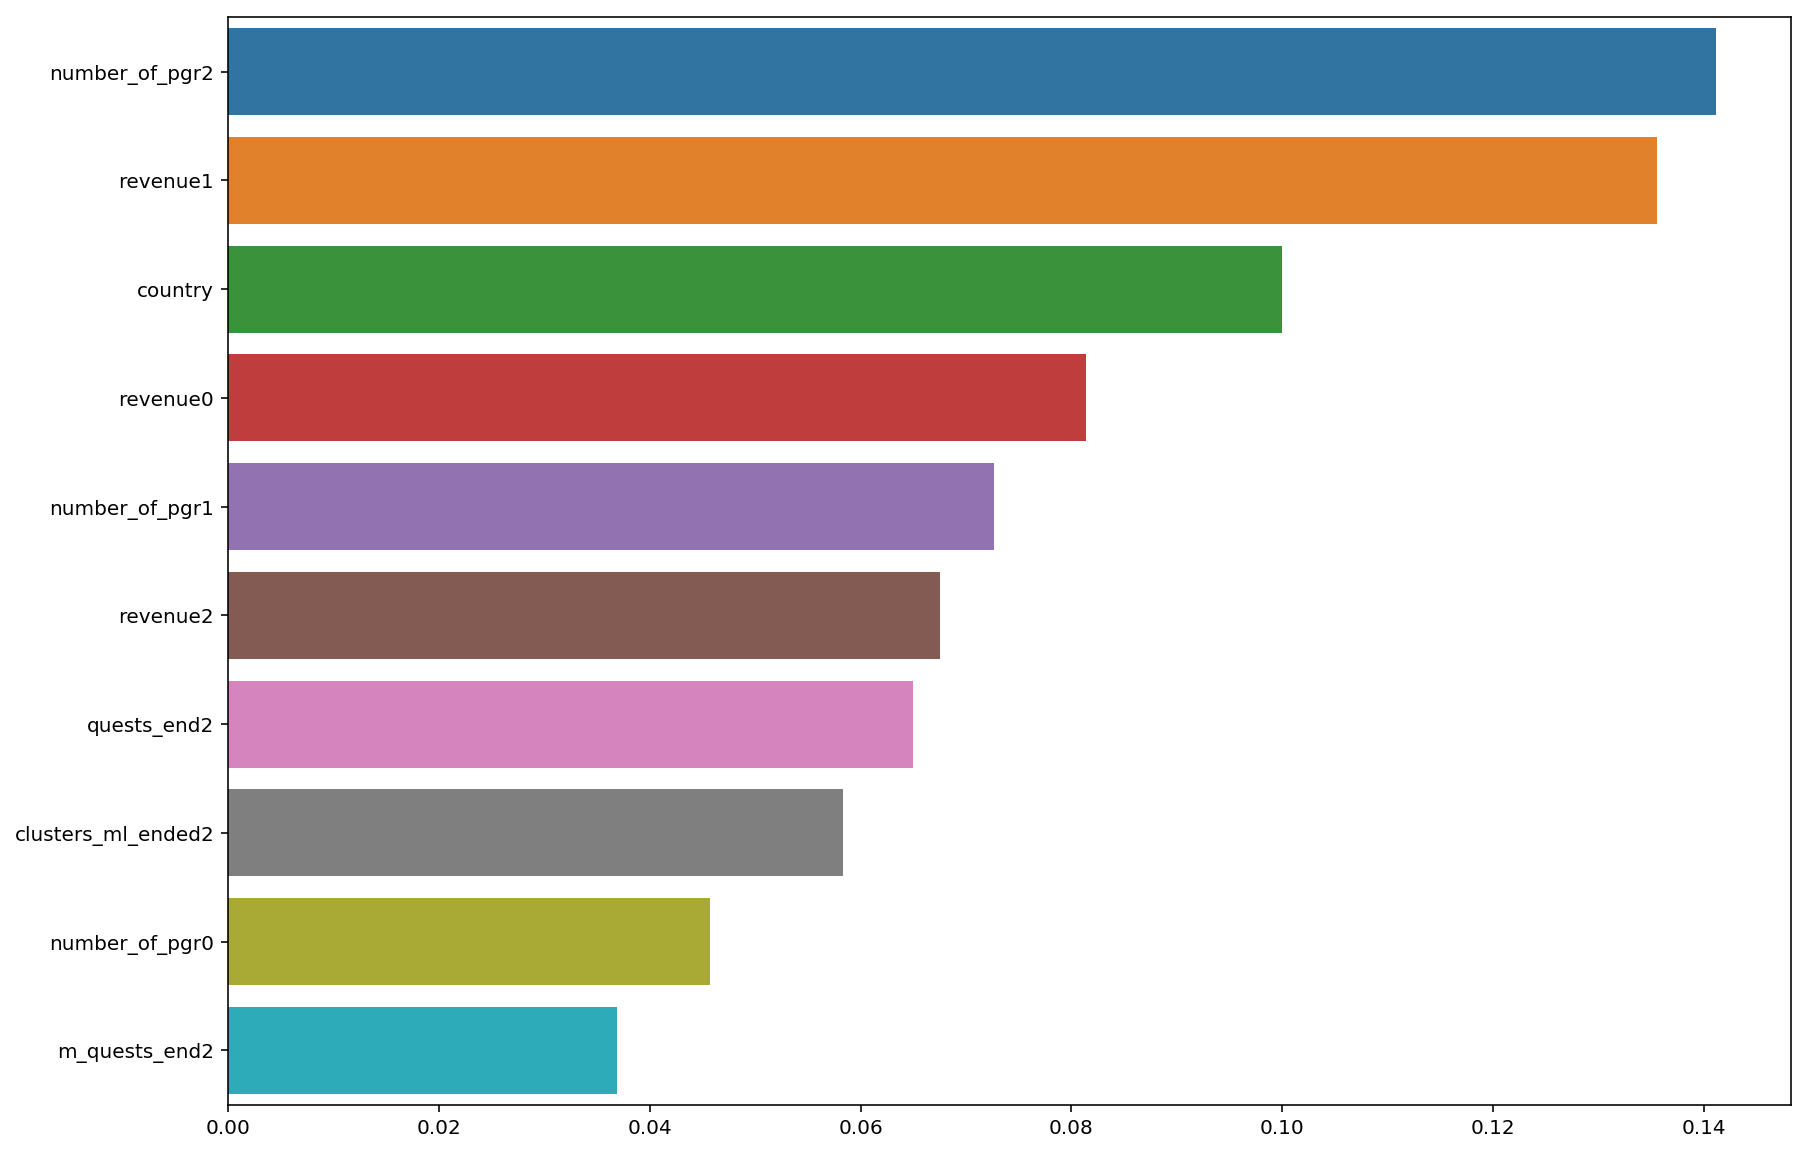

Timestamp: 28 Jul 01:20:08 Time period: 3-30


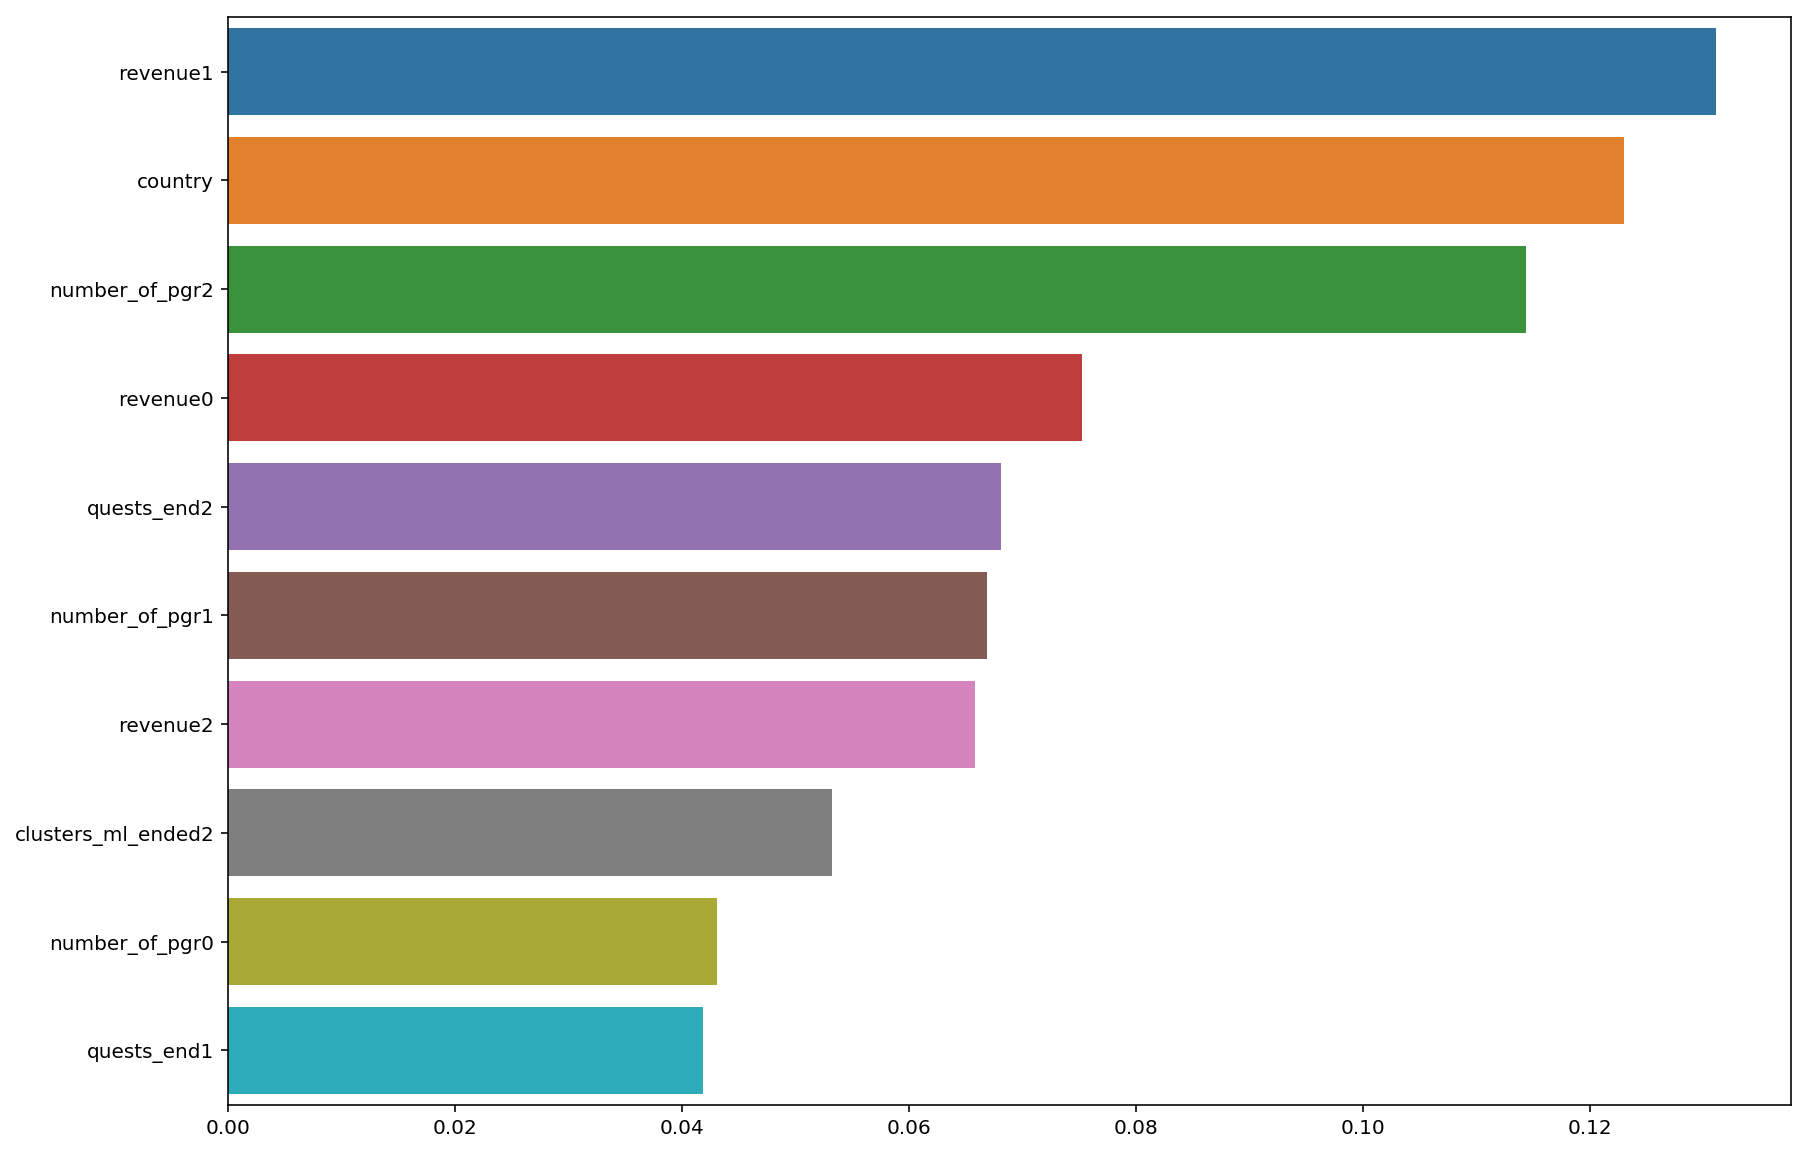

Timestamp: 28 Jul 01:20:24 Time period: 3-60


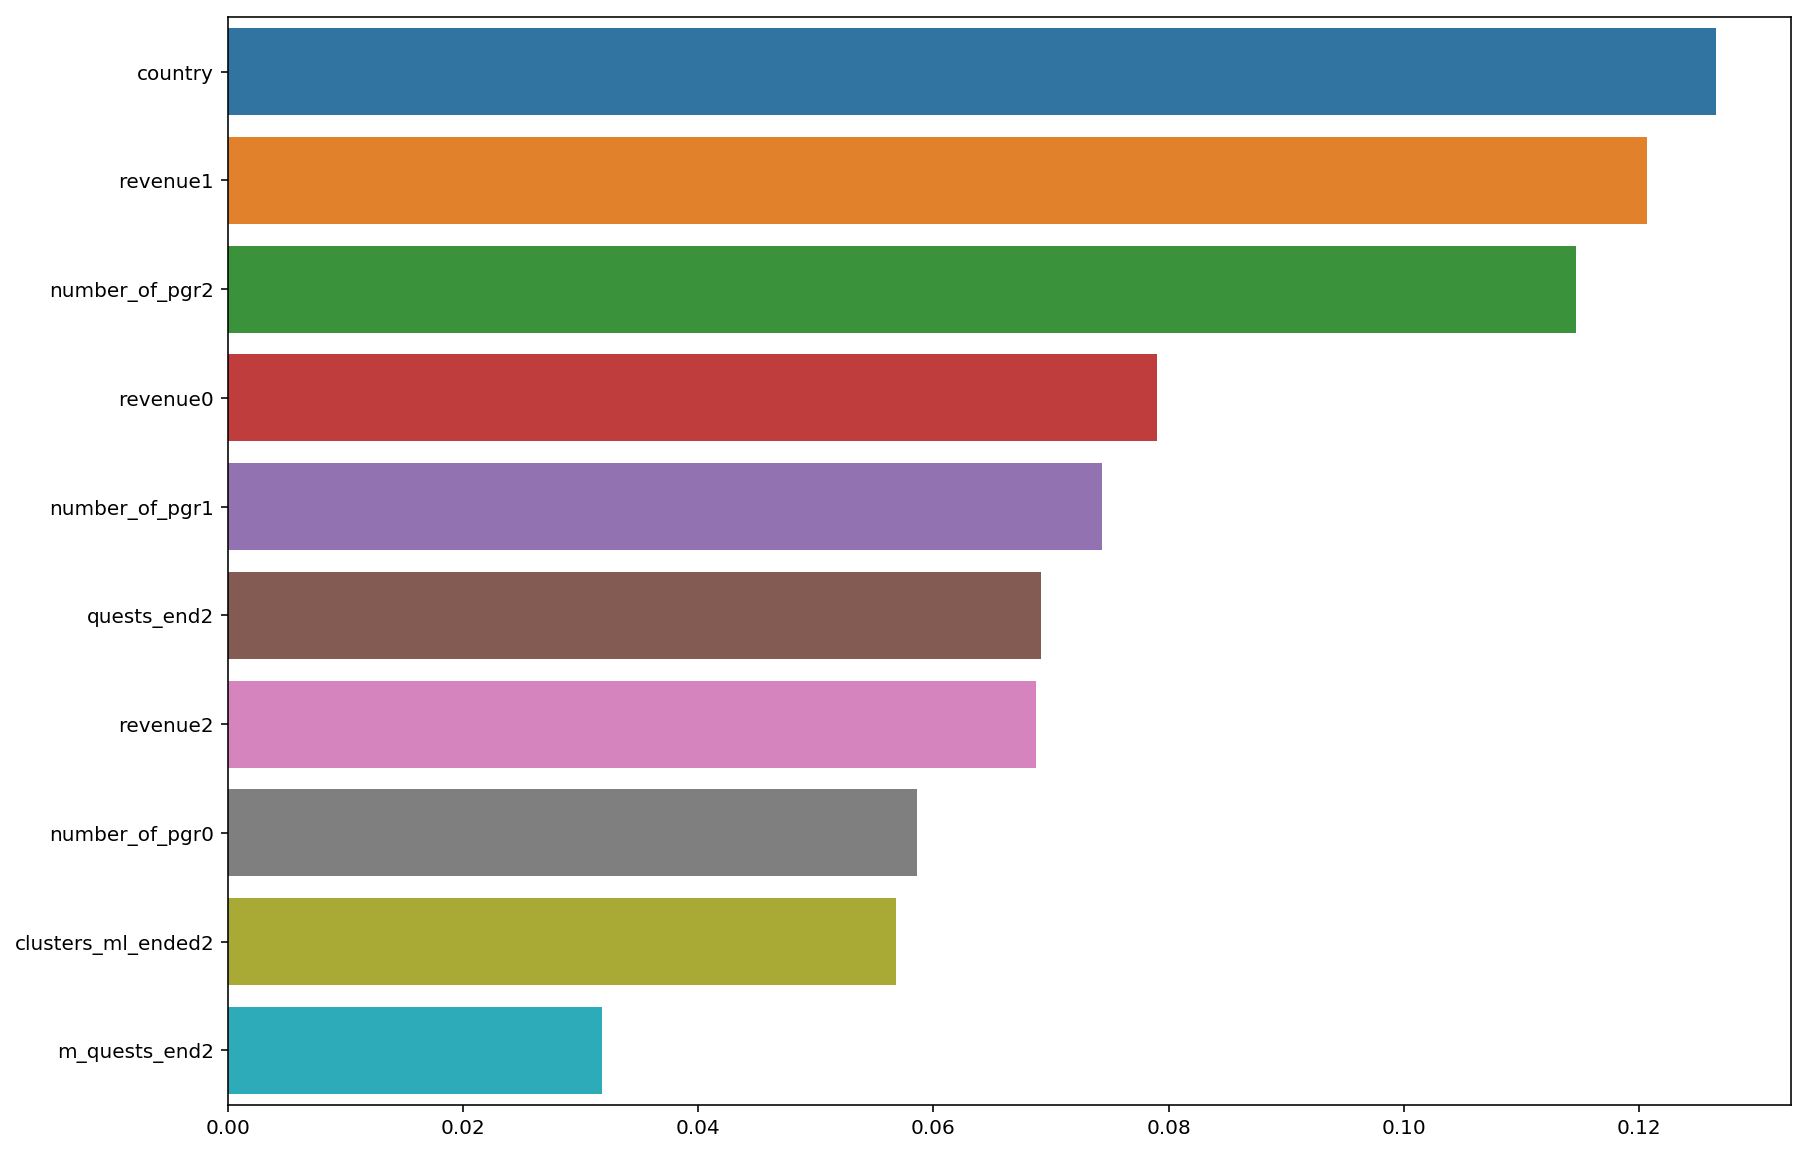

Timestamp: 28 Jul 01:20:41 Time period: 3-100


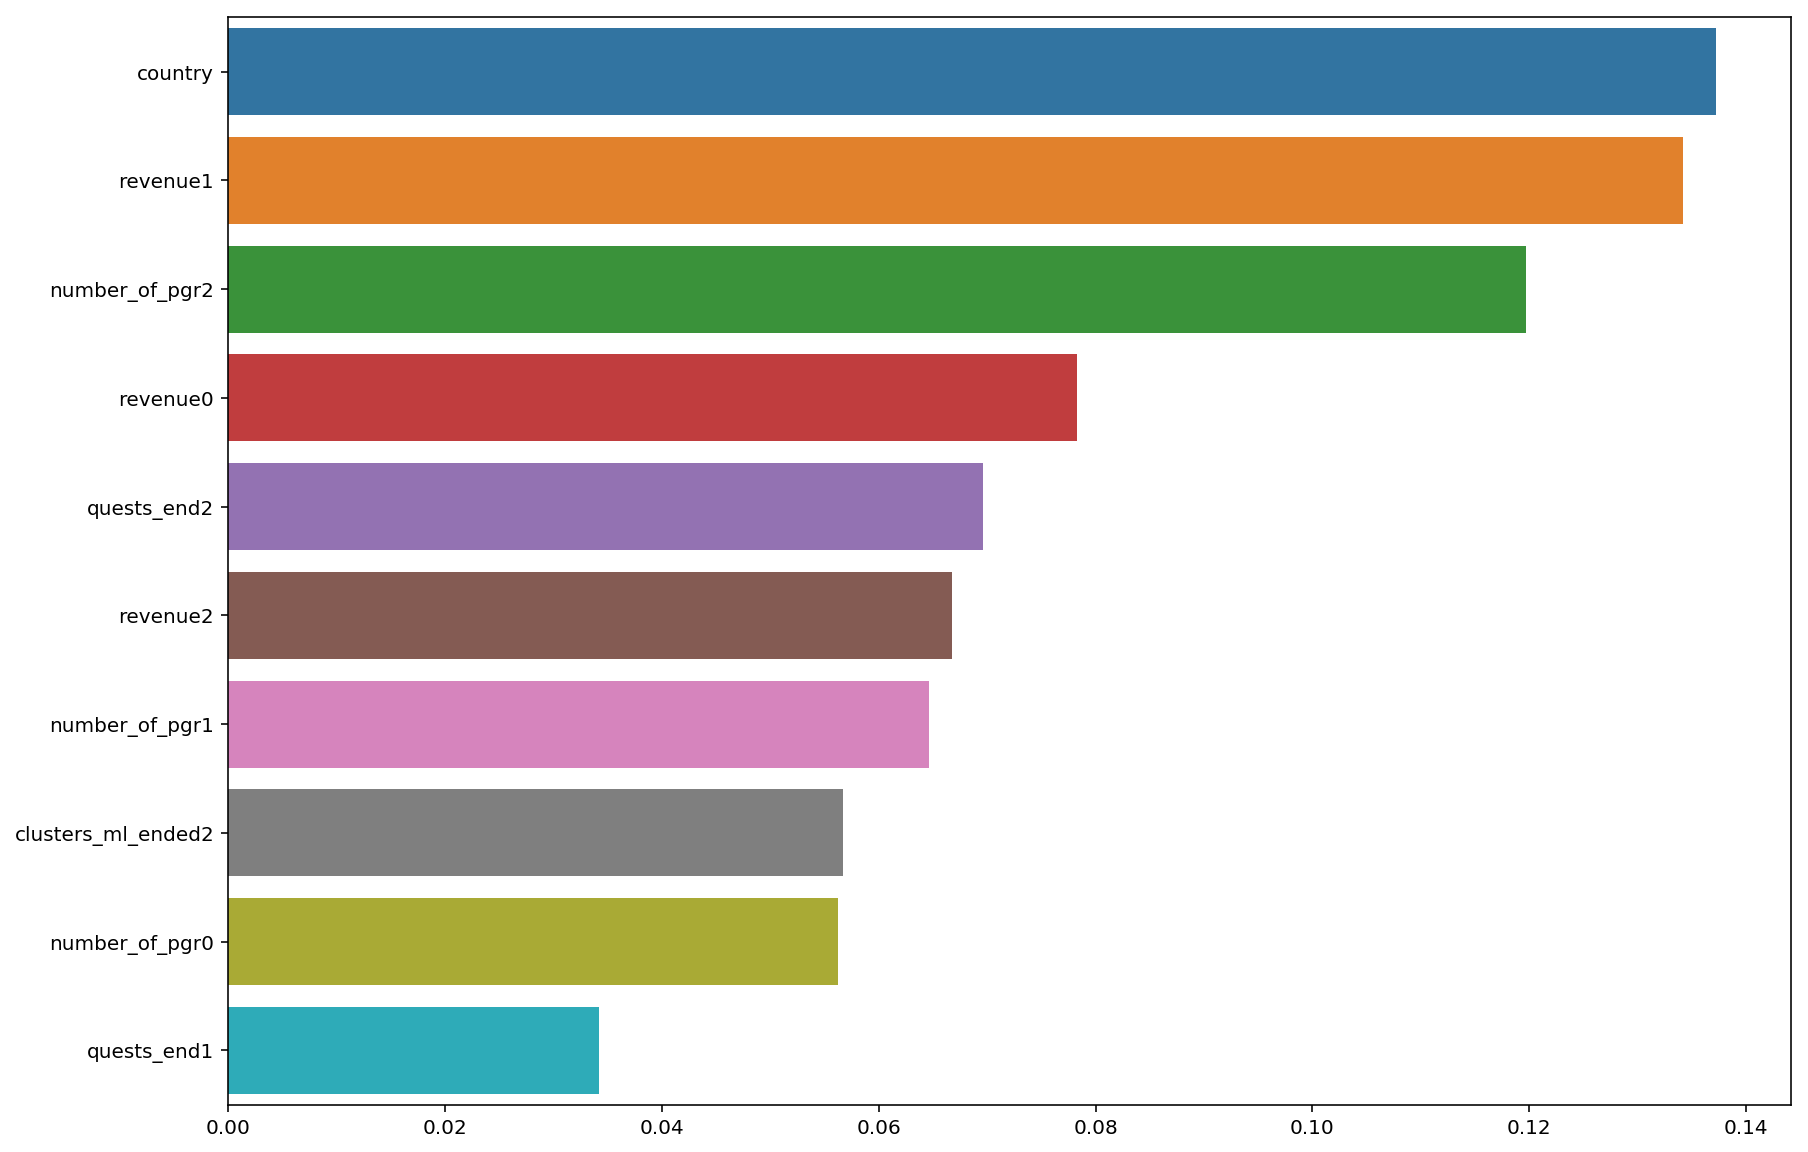

Timestamp: 28 Jul 01:20:57 Time period: 7-15


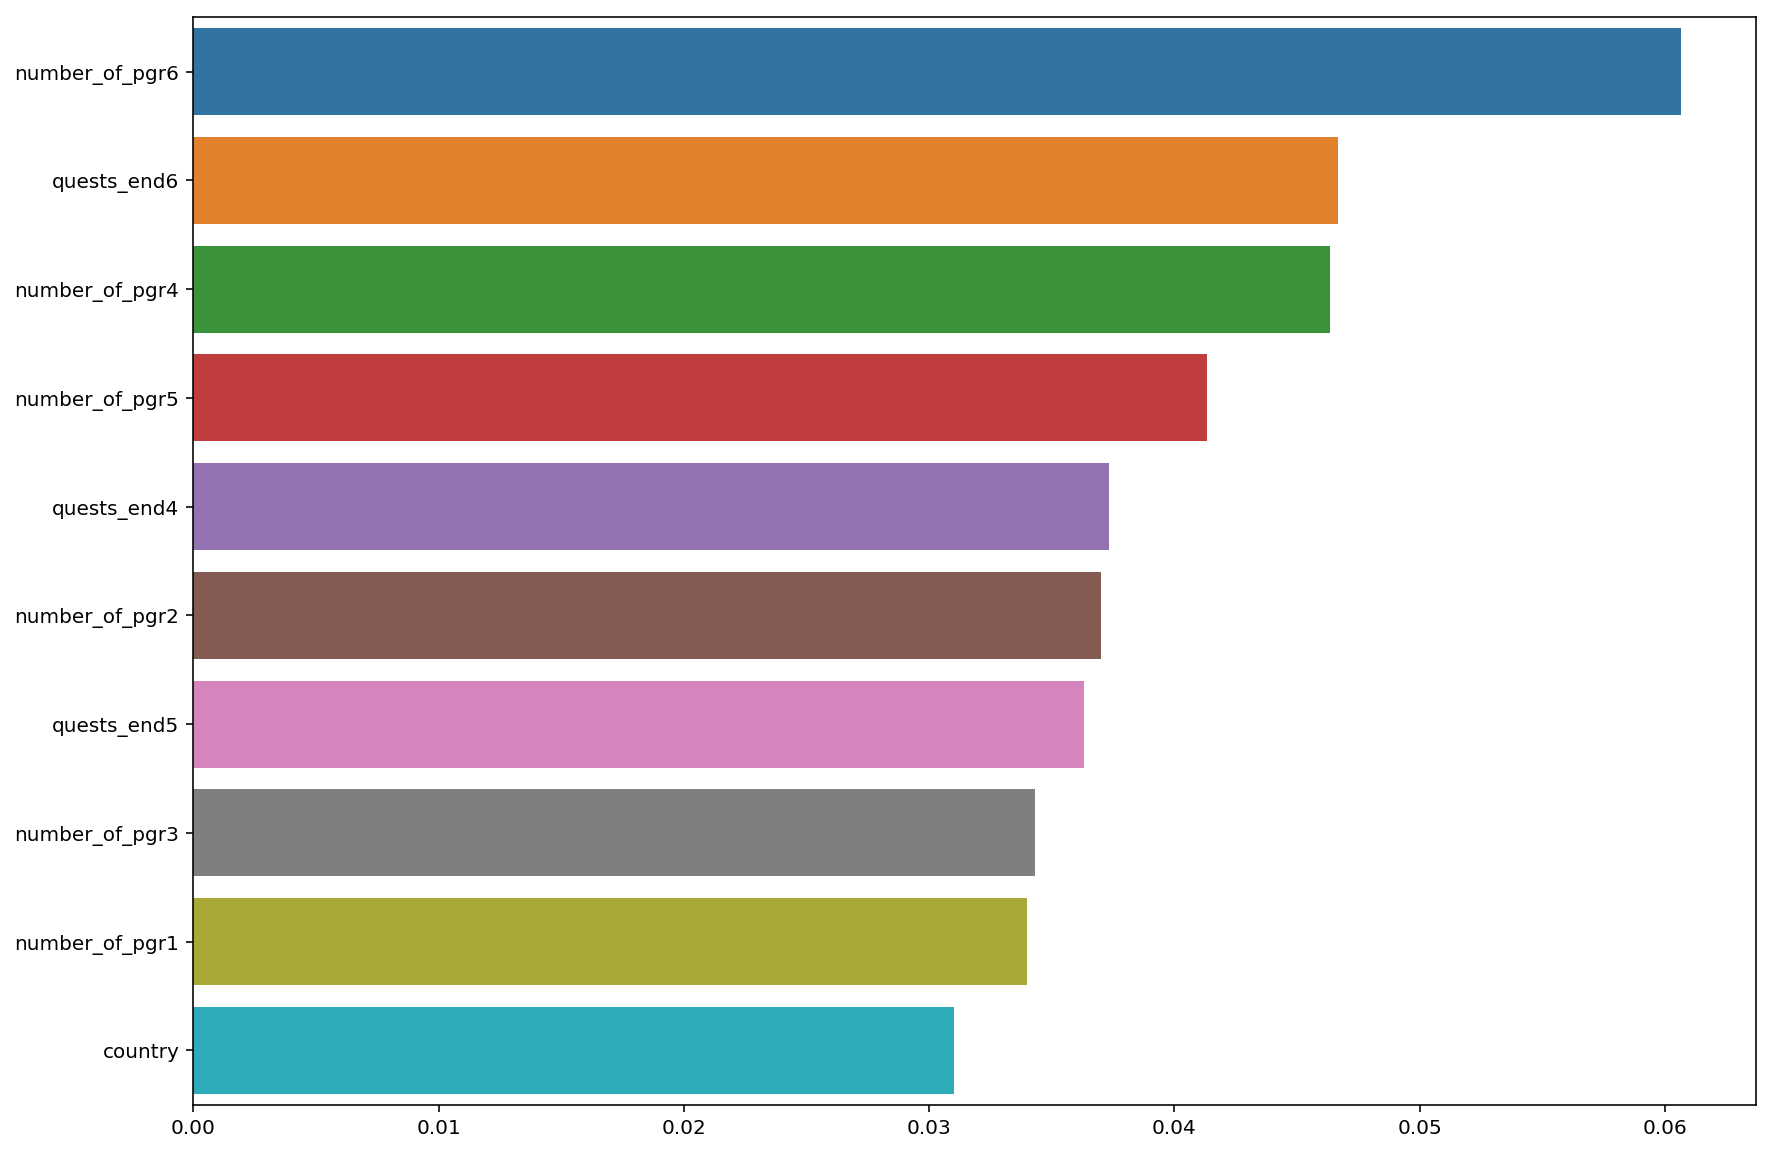

Timestamp: 28 Jul 01:21:34 Time period: 7-30


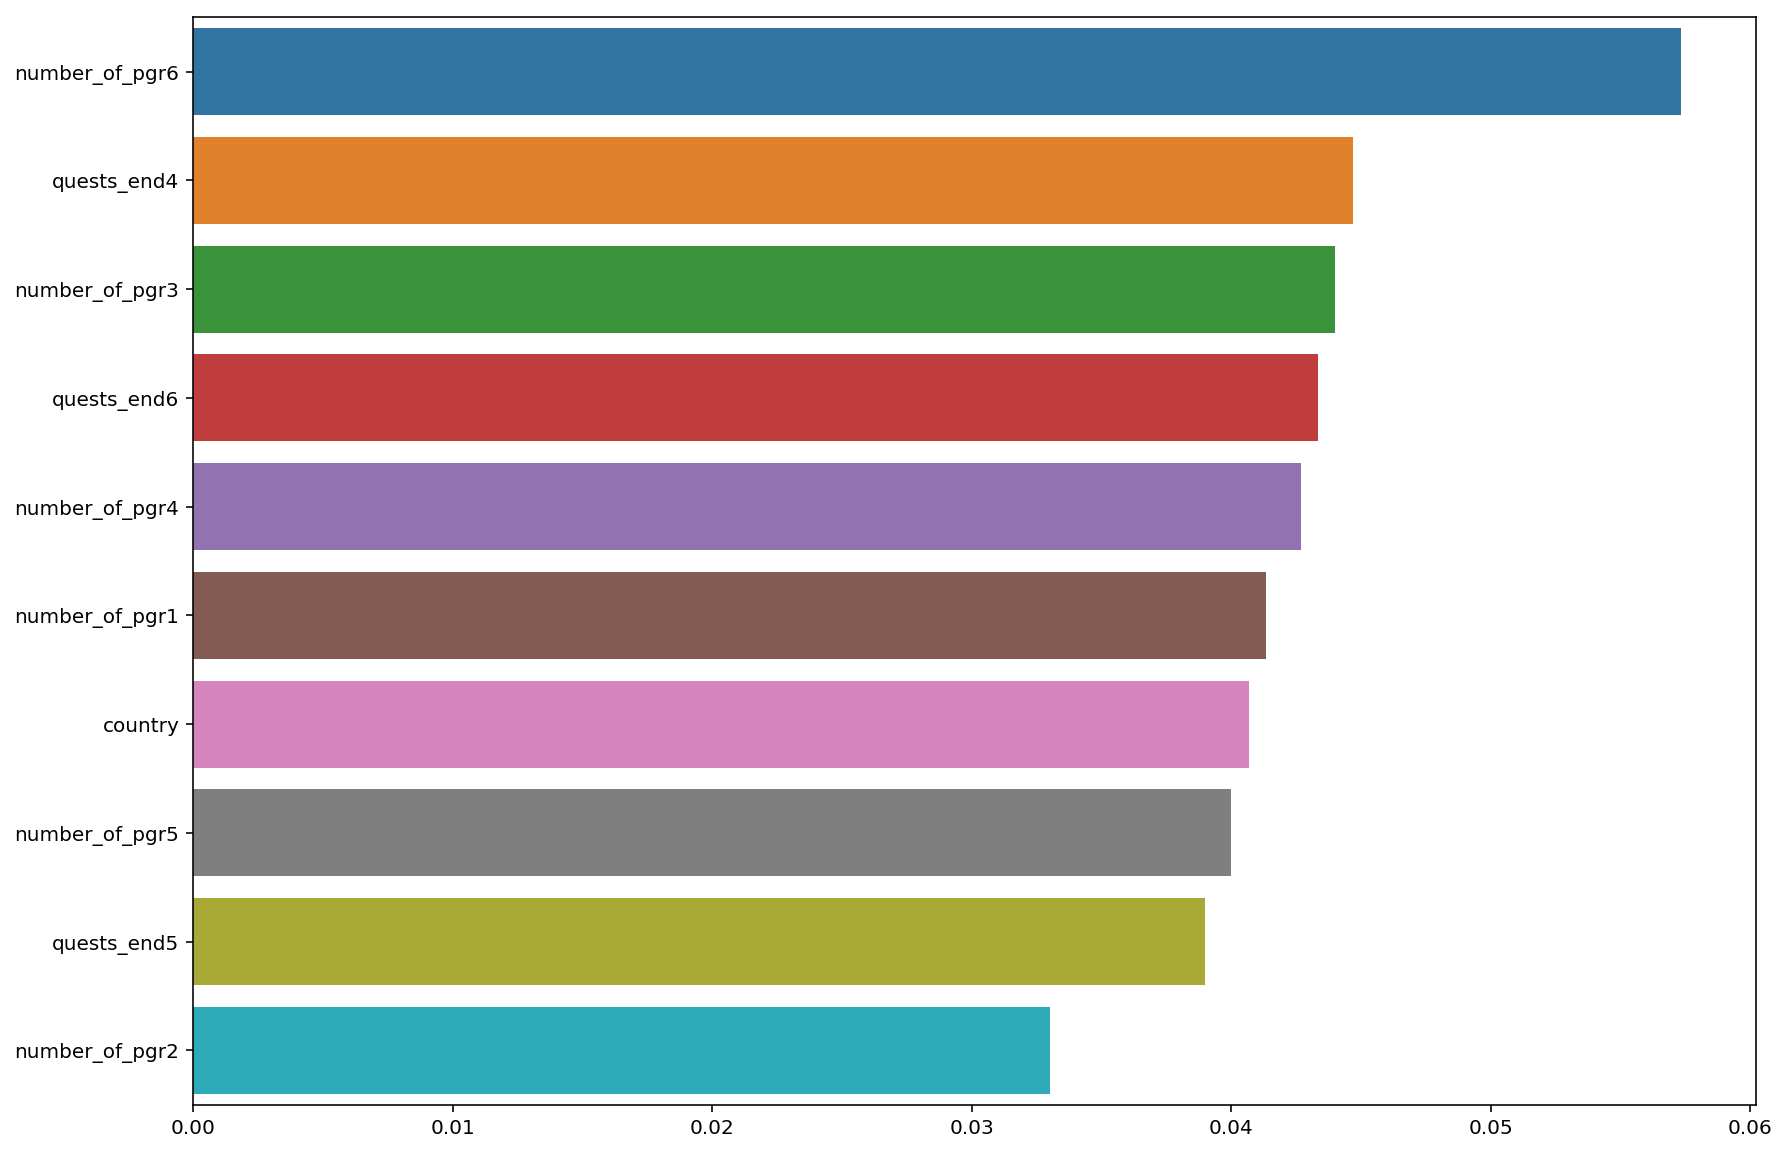

Timestamp: 28 Jul 01:22:10 Time period: 7-60


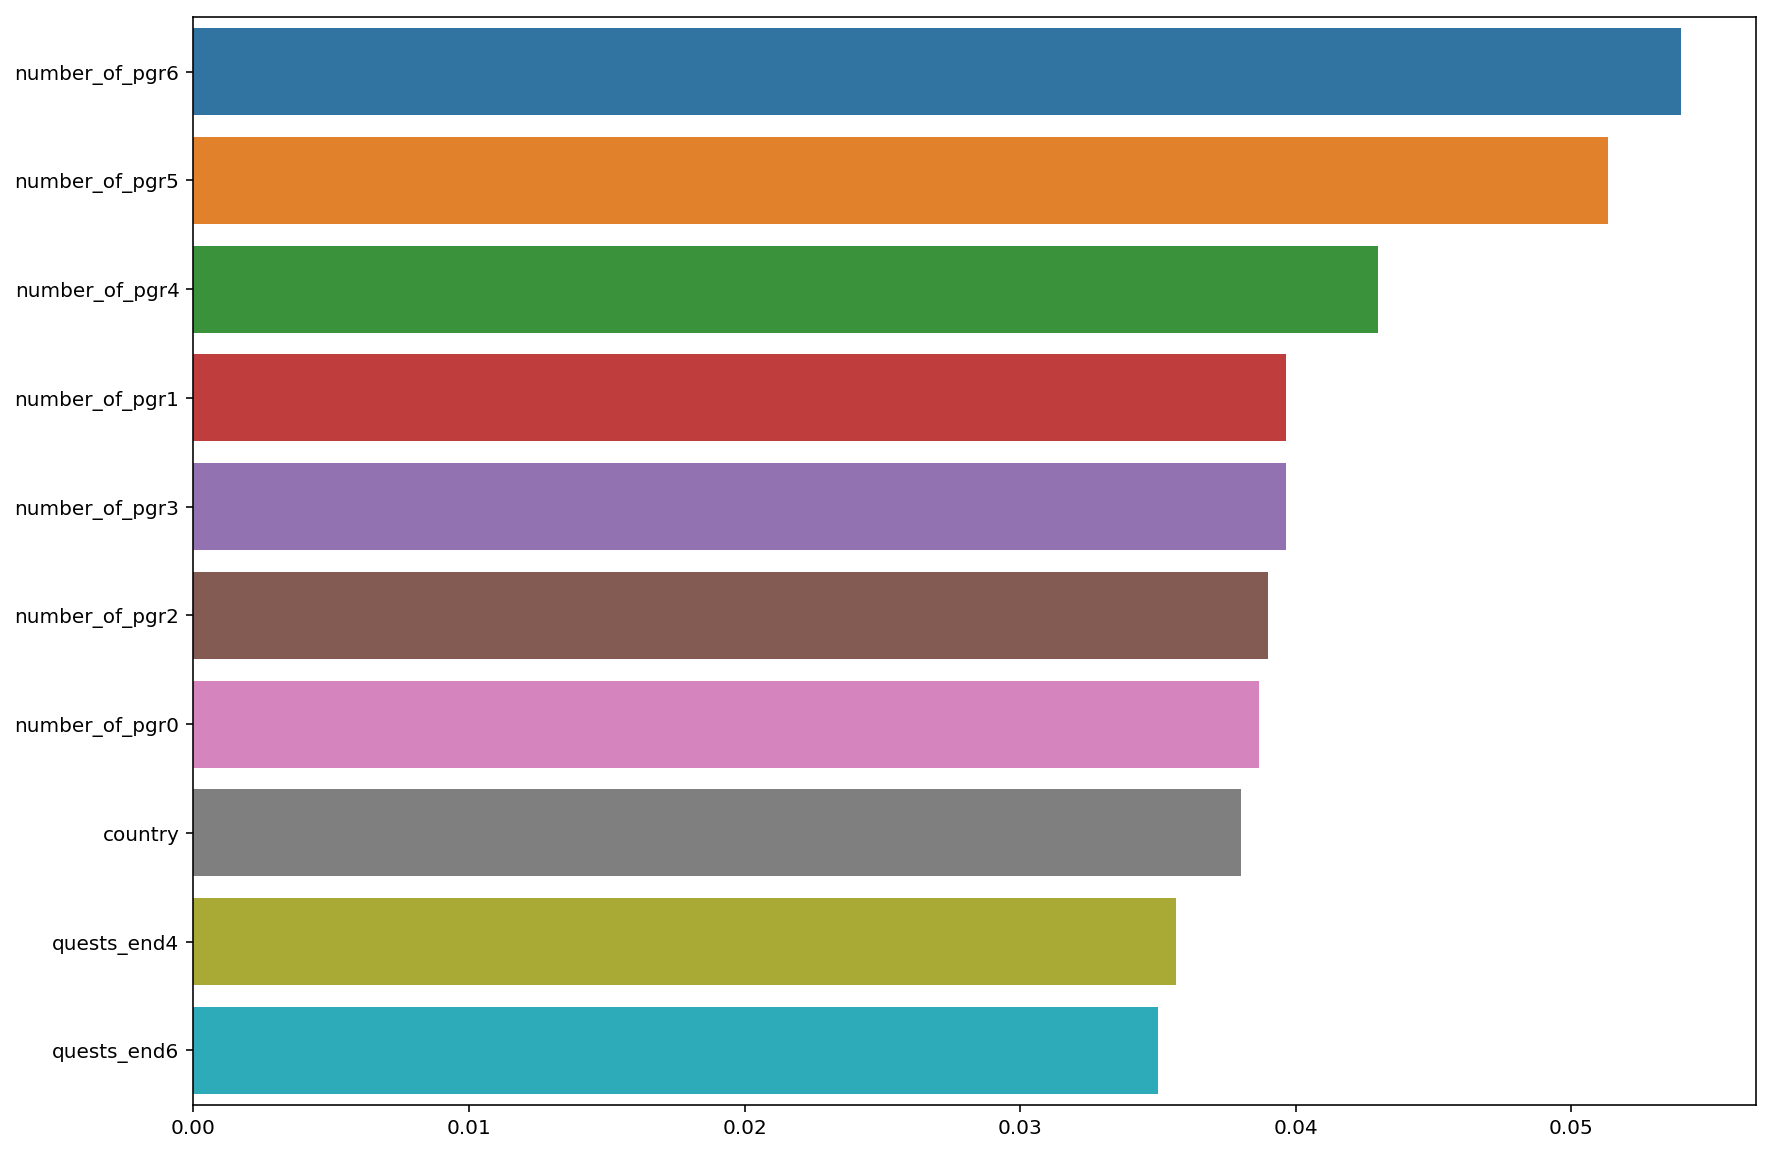

Timestamp: 28 Jul 01:22:48 Time period: 7-100


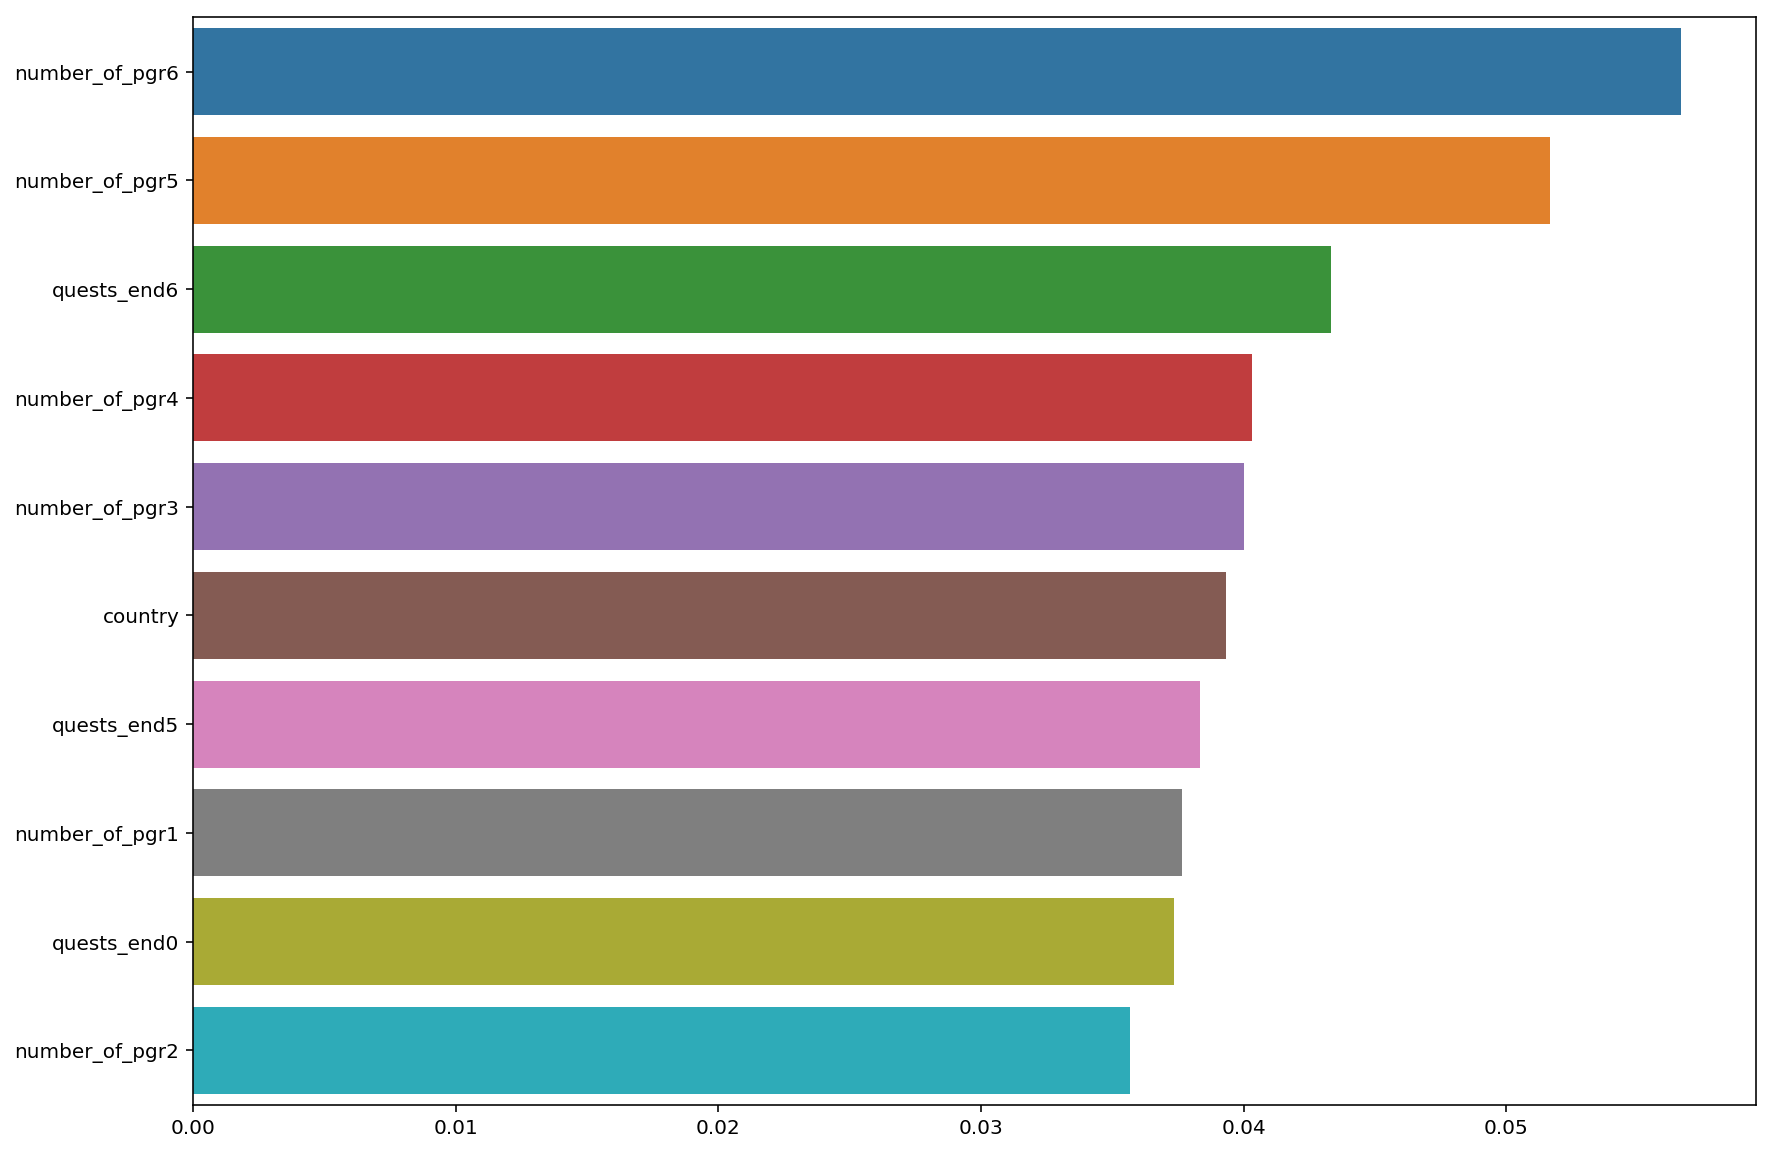

Timestamp: 28 Jul 01:23:25 Time period: 15-15


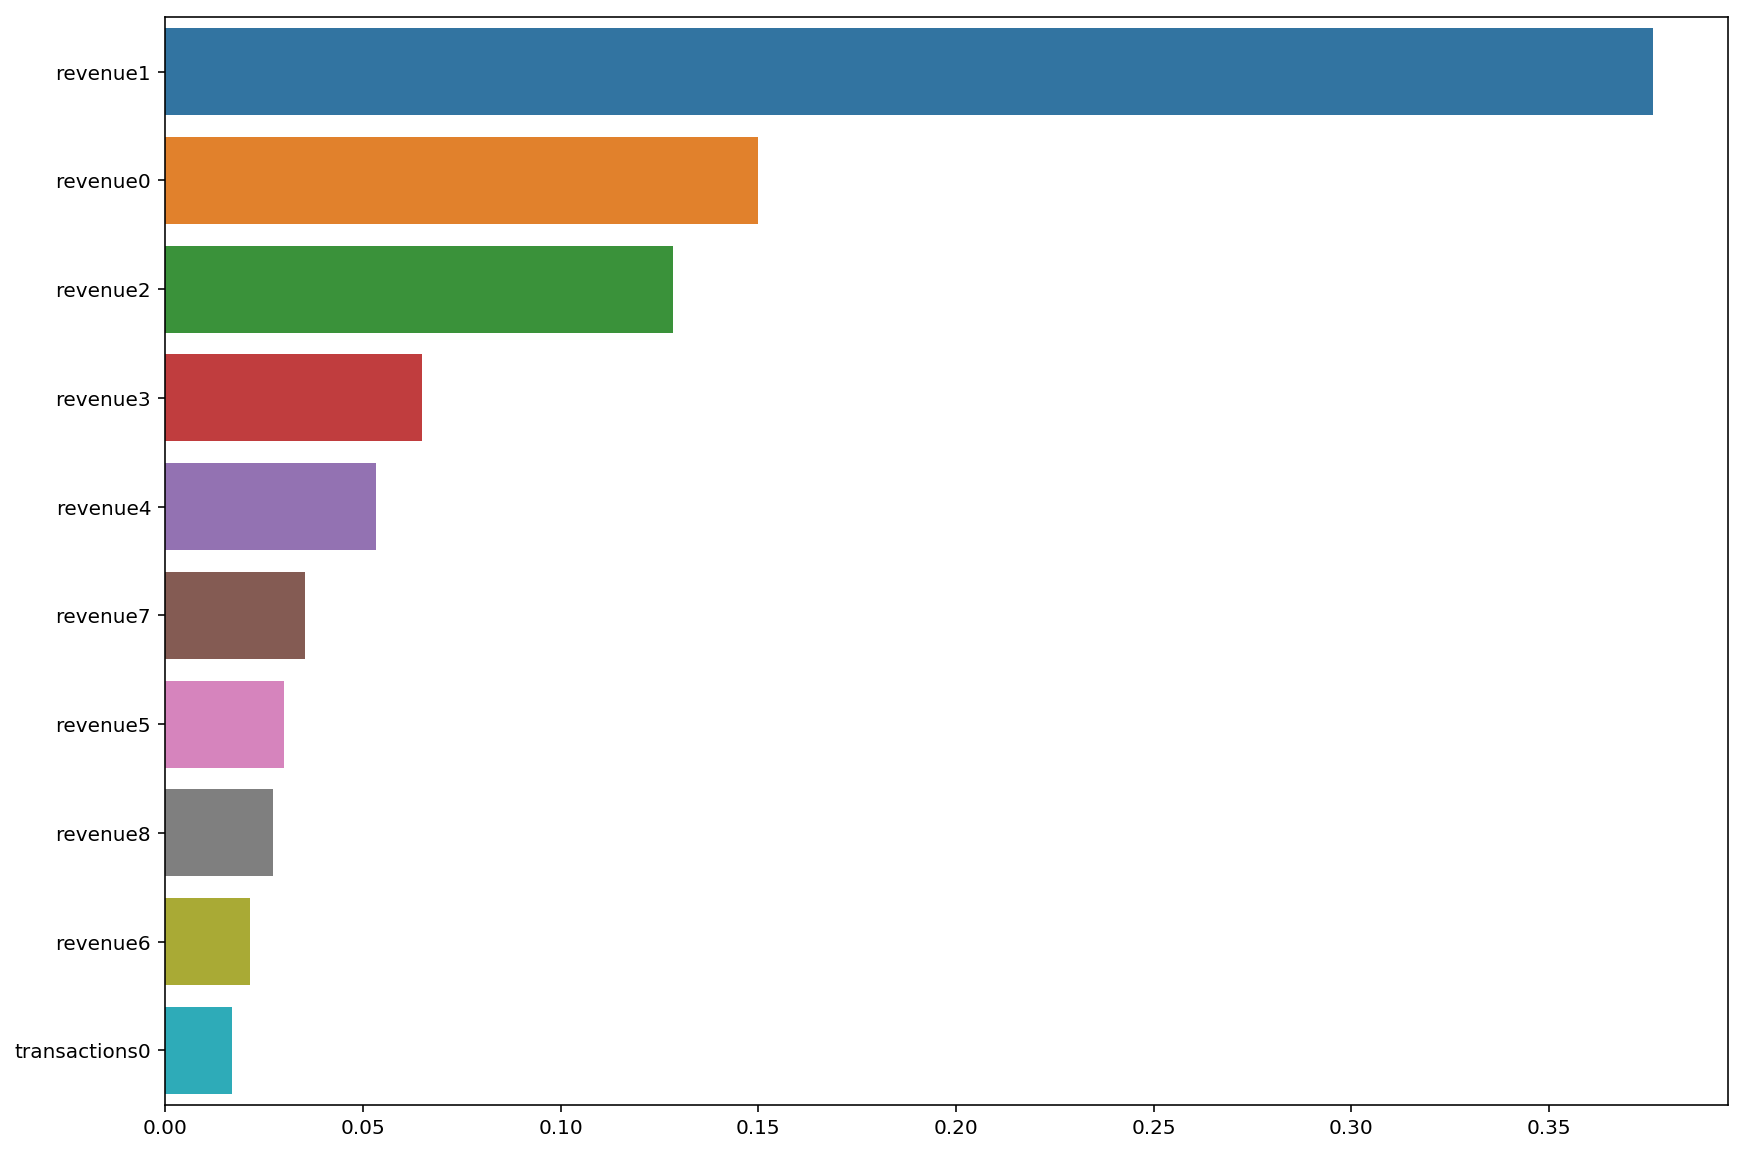

Timestamp: 28 Jul 01:24:30 Time period: 15-30


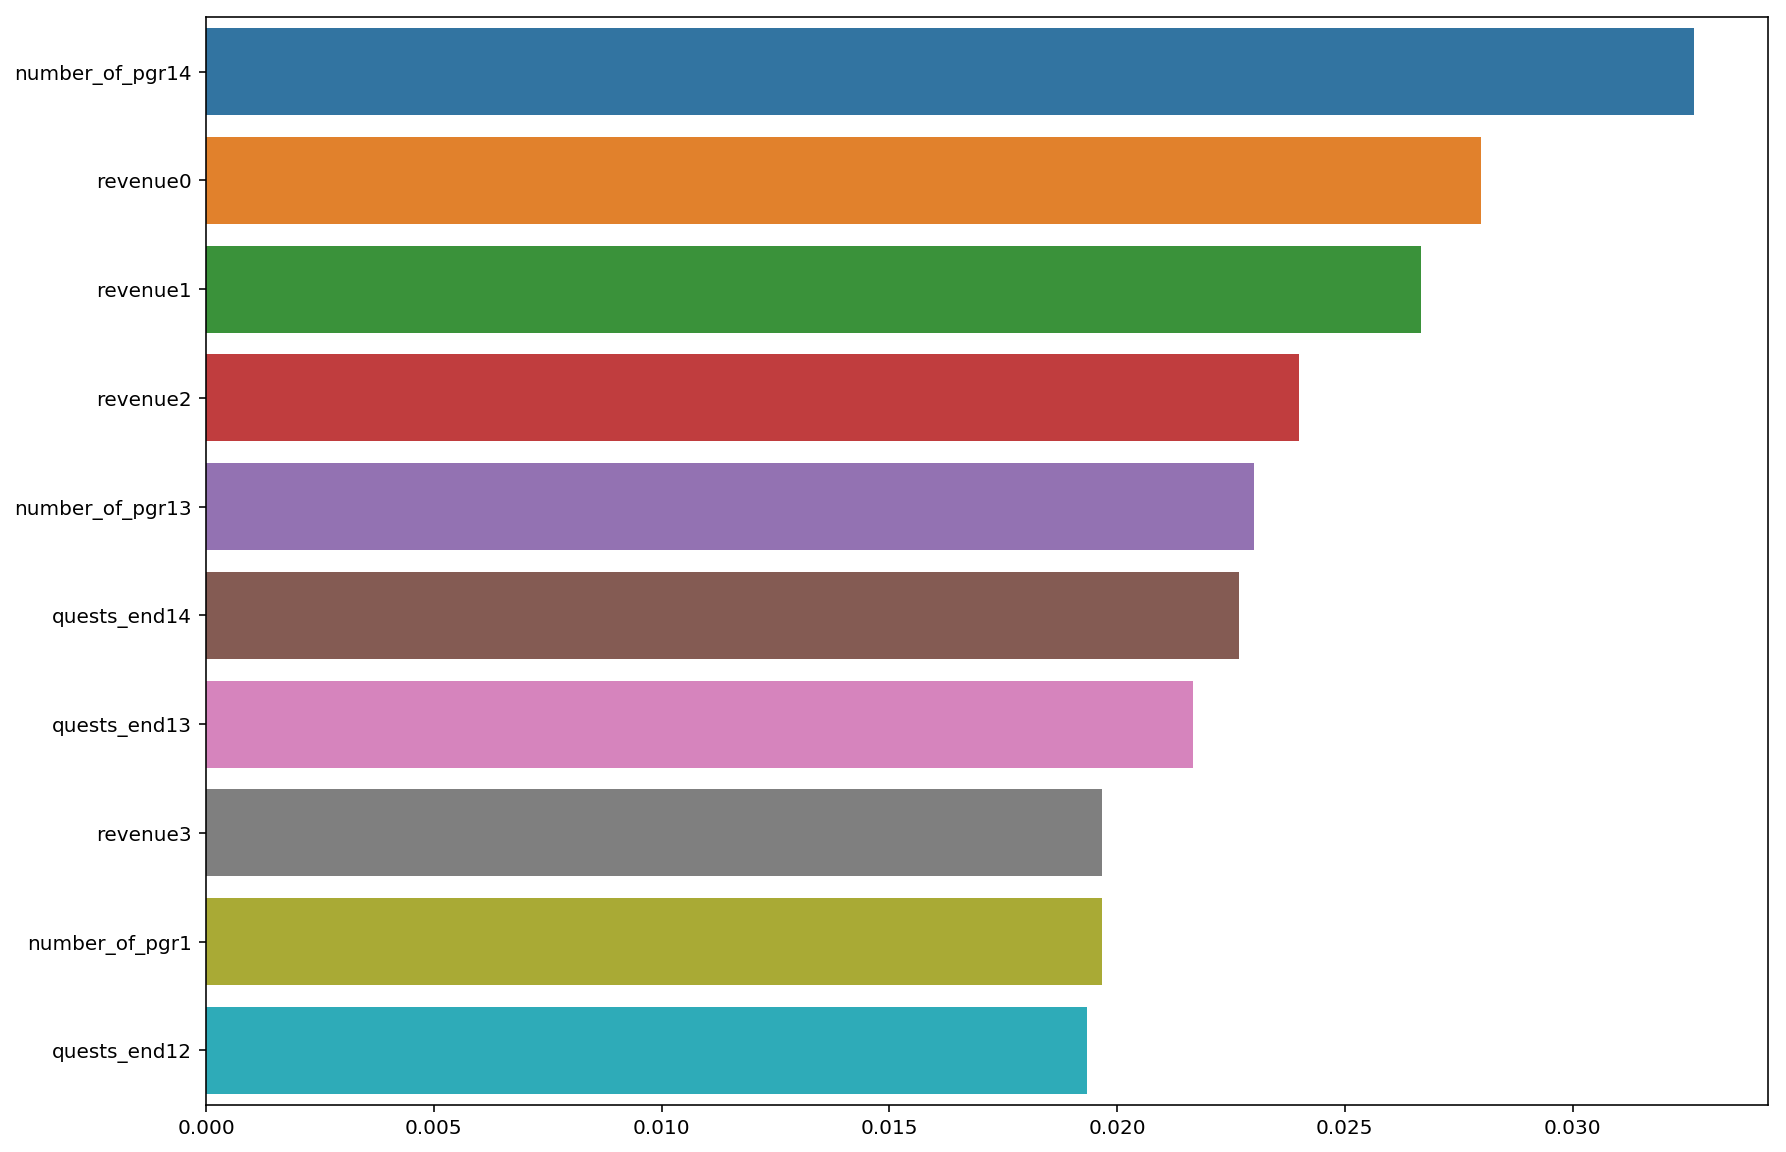

Timestamp: 28 Jul 01:25:47 Time period: 15-60


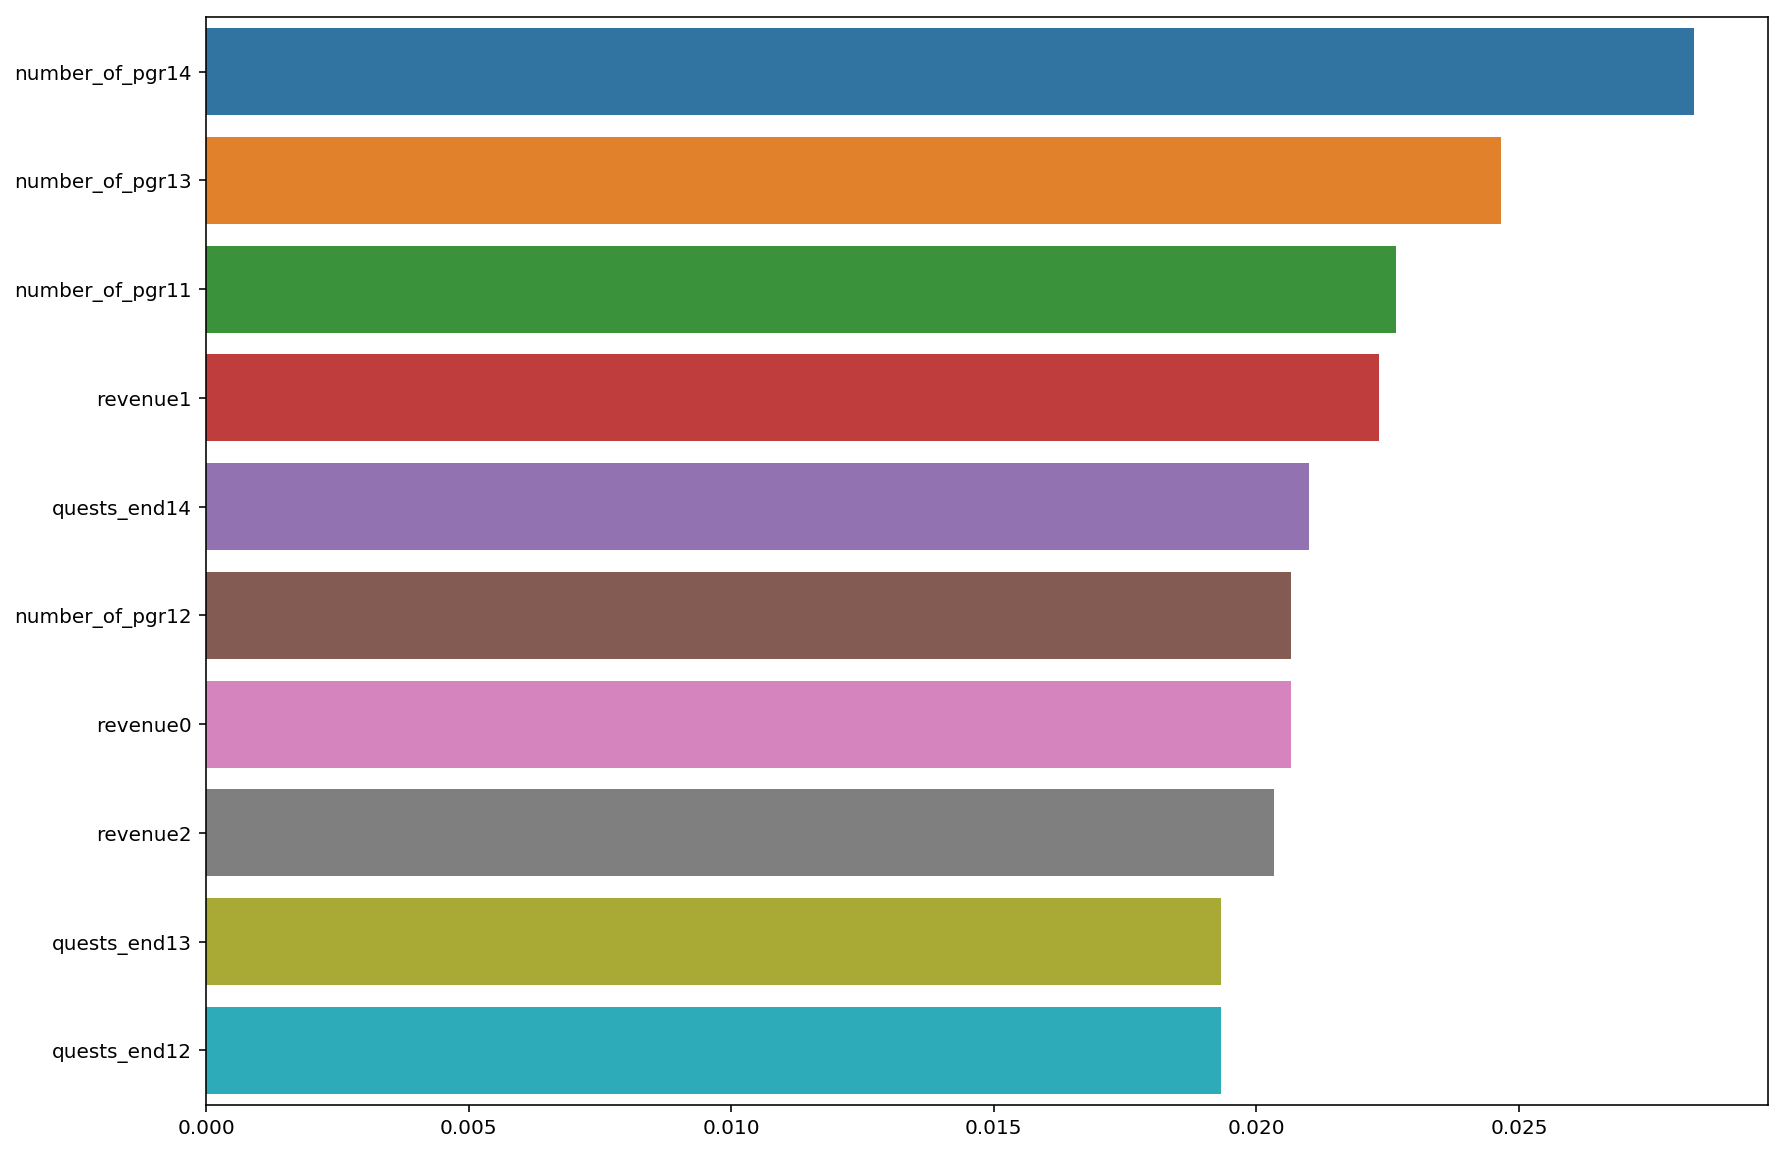

Timestamp: 28 Jul 01:27:08 Time period: 15-100


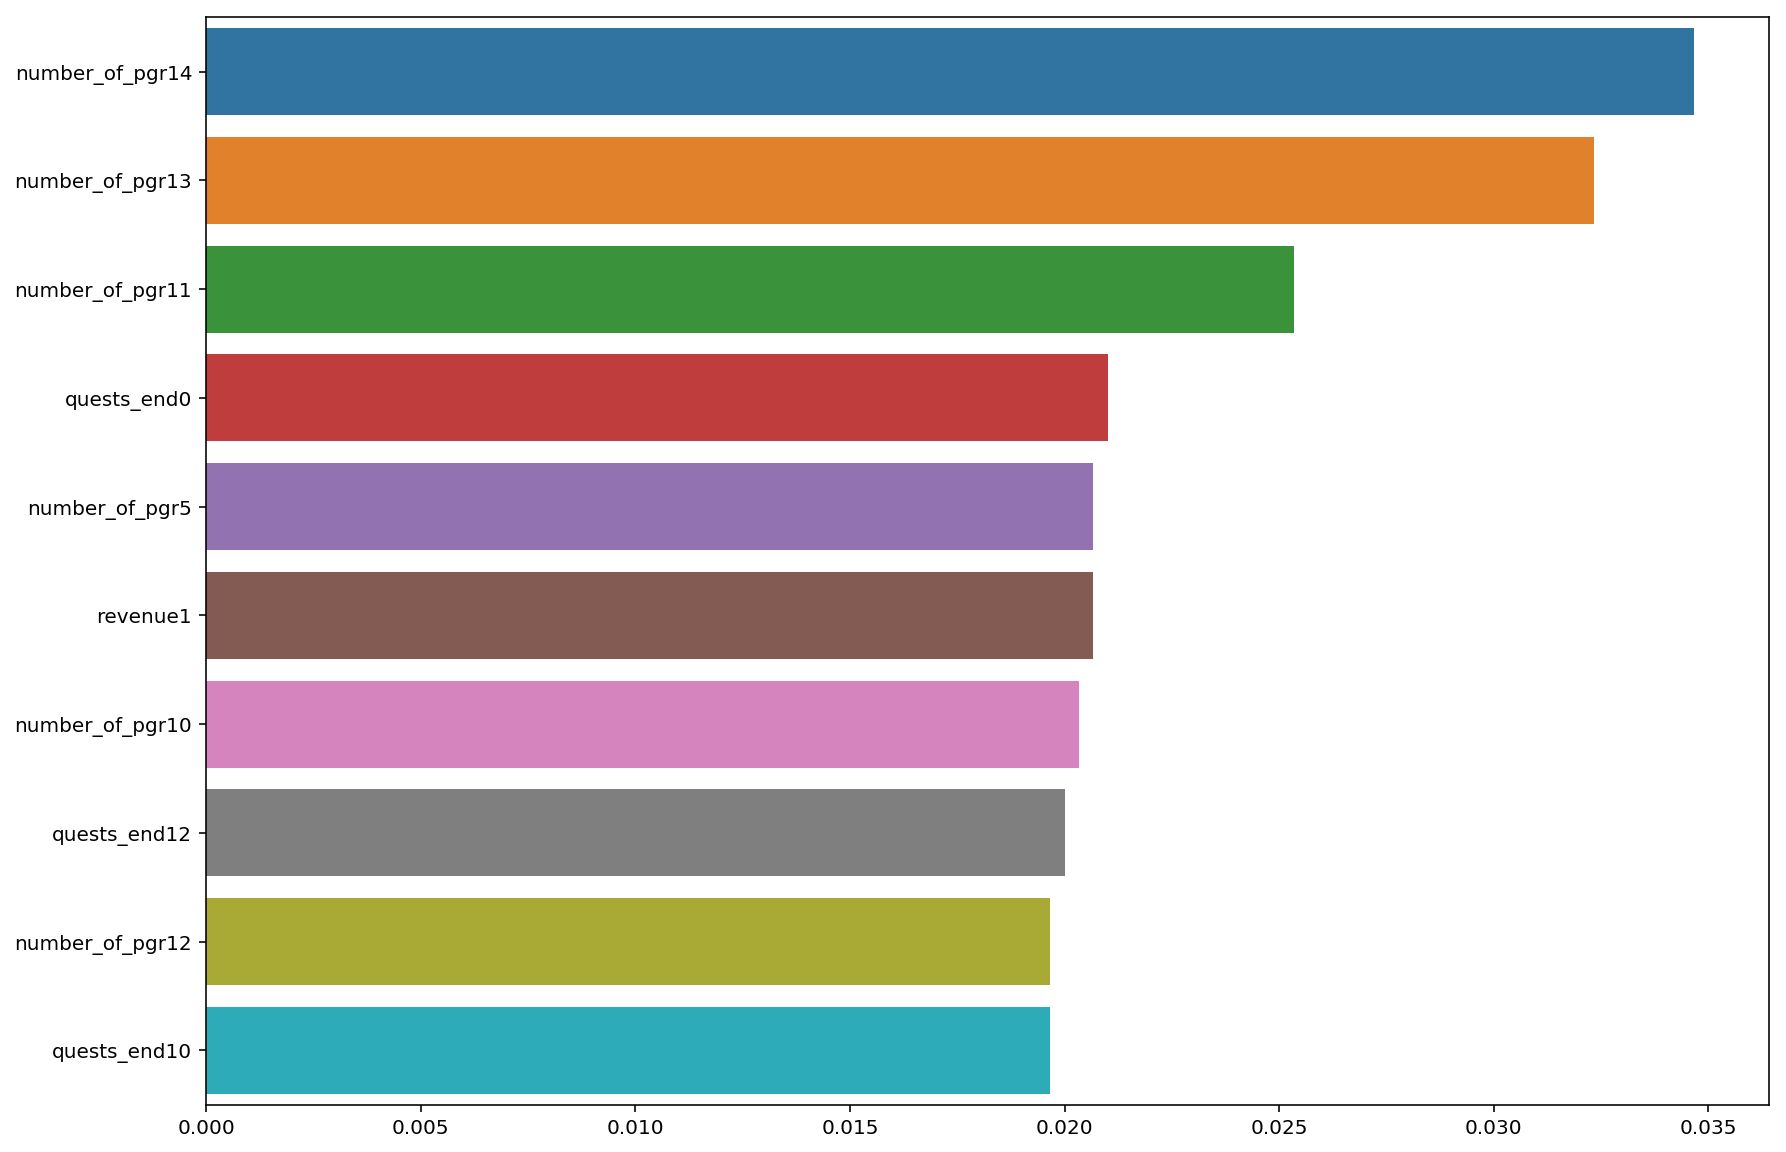

In [22]:
results_list=[get_models_scores(pact,obs,pred) for obs,pred in product([3,7,15],[15,30,60,100])]

In [23]:
pd.concat([item[0] for item in results_list])

,LightGBM,ElasticNet,RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,RMS of revenues
3-15,112.810579,127.131617,128.117750,128.929266,111.808192,195.445575
3-30,123.113178,136.605942,140.793609,138.683330,122.522867,202.371062
3-60,125.161997,138.664600,145.412154,144.165380,124.781310,203.819524
3-100,125.382764,138.700424,145.439995,145.473509,124.941139,203.819524
7-15,70.936503,113.671690,81.694563,81.681042,78.315698,195.499540
7-30,87.258050,124.088920,98.052329,100.232385,93.731454,202.422873
7-60,91.049633,126.287860,104.040304,105.098464,96.659728,203.870909
7-100,90.959914,126.337499,104.733058,104.064944,97.029408,203.870909
15-15,5.050004,109.294391,5.627093,3.791972,59.970323,195.497313
15-30,51.716061,120.001243,58.004375,57.762694,79.858516,202.420567


In [24]:
pd.concat([item[1] for item in results_list])

,LightGBM,ElasticNet,RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,Mean of revenues
3-15,29.646223,44.656961,39.187331,38.748056,29.704389,38.819481
3-30,34.669193,50.384428,46.478870,43.899709,34.723644,41.585976
3-60,35.905699,52.160419,51.003145,48.010720,36.647347,42.187523
3-100,36.102874,52.002322,50.966860,48.558033,36.681901,42.187523
7-15,11.975858,37.392502,17.337043,17.081627,18.350124,38.840549
7-30,17.582547,42.779230,23.138320,24.638987,24.618256,41.606918
7-60,20.327519,44.405002,27.391393,27.619651,26.824647,42.208443
7-100,20.434662,44.263970,27.548816,26.760944,27.679311,42.208443
15-15,0.301361,36.012807,0.263277,0.143384,15.038341,38.839664
15-30,6.812270,41.170995,8.448491,8.625357,21.352034,41.605968


In [25]:
pd.concat([item[2] for item in results_list])

,LightGBM,ElasticNet,RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,True sum
3-15,105287.843694,111985.122555,134083.486515,124203.084869,106550.591057,99173.484375
3-30,114312.628259,121576.683635,154705.308850,137316.789819,113490.768714,102747.984375
3-60,119257.774889,125908.887006,164168.759814,136644.708832,118236.823640,102747.984375
3-100,116908.991034,124638.076991,161791.798834,131331.526886,118667.161455,102747.984375
7-15,101226.876663,102736.834659,115448.103562,112075.897913,100444.613676,99173.484375
7-30,108815.961784,111337.455160,126795.079871,121857.503864,109729.210800,102747.984375
7-60,116393.589757,115044.831757,136639.686865,130855.576825,115016.255437,102747.984375
7-100,115528.736557,113412.638856,143460.116870,129831.316870,116818.131269,102747.984375
15-15,99373.498625,106778.700031,99304.743933,99297.009961,101524.926710,99173.484375
15-30,108141.174747,114066.845745,114873.584906,115157.340918,110009.382606,102747.984375


In [26]:
week_result_list=[get_week_results(pact,obs,pred) for obs,pred in product([3,7,15],[15,30,60,100])]

Timestamp: 28 Jul 01:28:30 Time period: 3-15
Timestamp: 28 Jul 01:28:35 Time period: 3-30
Timestamp: 28 Jul 01:28:40 Time period: 3-60
Timestamp: 28 Jul 01:28:45 Time period: 3-100
Timestamp: 28 Jul 01:28:50 Time period: 7-15
Timestamp: 28 Jul 01:28:59 Time period: 7-30
Timestamp: 28 Jul 01:29:09 Time period: 7-60
Timestamp: 28 Jul 01:29:18 Time period: 7-100
Timestamp: 28 Jul 01:29:27 Time period: 15-15
Timestamp: 28 Jul 01:29:44 Time period: 15-30
Timestamp: 28 Jul 01:30:02 Time period: 15-60
Timestamp: 28 Jul 01:30:20 Time period: 15-100


In [27]:
pd.concat([item[0] for item in week_result_list])

,LightGBM,ElasticNet,RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,True sum
3-15,39869.032567,39569.595376,46150.732959,46484.814954,38834.730846,43076.140625
3-30,44013.331464,42351.257595,48860.048950,47951.610950,42861.258506,44340.101562
3-60,46768.972590,44352.869524,51730.684949,55991.024927,44248.197234,46340.101562
3-100,46315.295387,45676.902198,57037.919952,56684.231927,45604.001974,46340.101562
7-15,44076.601065,41899.431916,45134.515942,47782.932922,44217.233374,43076.140625
7-30,47016.658634,44942.422782,51386.381934,51185.530939,47079.224724,44340.101562
7-60,49617.774603,47126.663978,52986.321924,55772.884918,48754.568662,46340.101562
7-100,51329.572077,48574.582207,57478.214929,58426.766925,50551.379952,46340.101562
15-15,42986.809817,41008.254379,43025.094934,43002.923926,43984.998802,43076.140625
15-30,47944.089574,44829.247762,46454.073944,50041.248920,47385.413434,44340.101562


In [28]:
pd.concat([item[1] for item in week_result_list])

,LightGBM,ElasticNet,RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,True sum
3-15,35592.451590,36641.194429,40830.741949,40345.295959,36243.179559,37361.453125
3-30,39147.801658,38988.147005,43196.428280,44290.218915,38659.827329,42203.941406
3-60,40683.060973,40616.340782,48180.266943,48109.836938,40299.259583,44203.941406
3-100,41218.148791,41729.902796,49913.159617,48701.296930,41382.966876,46203.941406
7-15,36437.584387,34855.692624,37814.121936,38779.170929,37271.299589,37361.453125
7-30,39174.354194,37510.572890,42847.186269,44329.692914,39718.143368,42203.941406
7-60,41444.463824,39315.715787,45125.766931,46311.911920,41152.742890,44203.941406
7-100,42568.110711,40606.130934,46076.199939,47206.178925,42820.238823,46203.941406
15-15,37098.597812,34869.684350,36911.941931,36981.335938,38668.582625,37361.453125
15-30,40943.258822,38133.649021,42148.519946,43594.398914,41048.419224,42203.941406


In [29]:
pd.concat([item[2] for item in week_result_list])

,LightGBM,ElasticNet,RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,True sum
3-15,38714.750550,35635.475635,47194.909924,49305.701953,39061.395304,44203.941406
3-30,42700.772648,38401.917284,49996.566925,50380.559955,42675.022726,45203.941406
3-60,45463.609992,40375.558207,57644.495231,57754.596960,44593.792299,53106.000000
3-100,46074.928379,41705.538710,60676.788218,58927.259930,46020.593533,55106.000000
7-15,41103.438441,37323.903649,41779.976923,44694.488928,41246.935100,44203.941406
7-30,44322.263999,40251.314382,47779.080908,49147.145905,44406.993643,45203.941406
7-60,47213.634827,42294.643985,54154.733776,55465.798588,46042.498711,53106.000000
7-100,48140.776071,43763.700966,56051.063787,60372.660944,47258.080754,55106.000000
15-15,44002.751149,36585.694126,43868.450928,44070.690930,43353.983221,44203.941406
15-30,47724.993003,41673.718543,49021.197913,50225.885907,46658.609135,45203.941406


In [30]:
pd.concat([item[3] for item in week_result_list])

,LightGBM,ElasticNet,RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,True sum
3-15,50137.859878,46617.893831,61849.330227,58862.209906,50535.767532,56999.398438
3-30,54000.155258,49382.962566,62816.134237,65375.048883,54386.291622,60135.710938
3-60,56146.155155,51325.744094,65329.817226,73962.702930,55838.092487,62135.710938
3-100,56536.646466,52658.447842,66584.039893,69131.632886,56965.110378,62978.199219
7-15,54071.383432,49225.131477,57312.194928,59201.534906,52434.418870,56999.398438
7-30,57269.530599,52246.370329,63159.372906,62397.384924,55293.558688,60135.710938
7-60,59488.006865,54310.773247,66296.413898,68710.686896,57374.300792,62135.710938
7-100,60246.874661,55775.191551,67335.081891,70856.177911,59442.621174,62978.199219
15-15,56977.488096,52214.701193,56924.601929,56801.161920,53512.404013,56999.398438
15-30,60057.020879,54598.741472,61874.795917,62893.860913,57059.514049,60135.710938


In [31]:
pd.concat([item[4] for item in week_result_list])

,LightGBM,ElasticNet,RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,True sum
3-15,48230.828216,42431.873346,57469.128249,59573.497943,48858.645002,54088.984375
3-30,52056.302264,45029.822766,59148.562258,65320.242932,52345.577683,57088.984375
3-60,55066.592183,46929.428835,66337.641256,69869.361932,54393.627153,58505.968750
3-100,56128.156573,48249.364281,69661.130408,68956.178925,55860.767037,60505.968750
7-15,53525.714650,46655.545193,54755.312946,59910.194922,54476.043042,54088.984375
7-30,57235.918273,49706.288642,59968.480939,60385.635944,57555.852419,57088.984375
7-60,59412.039389,51847.789262,63549.743951,68003.789917,59501.413205,58505.968750
7-100,61391.919767,53388.536599,69151.818921,69793.637921,60841.756467,60505.968750
15-15,54591.582240,49246.413407,54612.717914,54287.605914,56200.591760,54088.984375
15-30,57564.051608,50207.388466,57250.176923,57964.703918,58950.782344,57088.984375


In [32]:
pd.concat([item[5] for item in week_result_list])

,LightGBM,ElasticNet,RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,True sum
3-15,76363.842624,71572.753643,85042.262897,86317.135889,74806.915325,78331.140625
3-30,80455.821259,74995.842287,87467.359906,89721.136908,78544.156622,81488.656250
3-60,84243.253637,77558.397577,92890.799896,98938.754913,80897.672618,83331.140625
3-100,88023.091398,79339.146776,92116.687897,94444.471893,82700.207738,84331.140625
7-15,77327.567944,71048.611662,80323.315869,84433.154877,74734.814963,78331.140625
7-30,81102.843850,75005.369997,88239.604883,88513.566876,77875.384211,81488.656250
7-60,85753.453953,77823.604331,91834.423877,92951.204871,80534.728523,83331.140625
7-100,87453.585825,79832.410623,98340.798871,99305.041864,82999.751837,84331.140625
15-15,79037.042614,73121.775366,78860.118890,78730.766901,74525.838674,78331.140625
15-30,82143.014802,76146.217880,81953.325885,84200.981897,77895.230100,81488.656250


In [33]:
pd.concat([item[6] for item in week_result_list])

,LightGBM,ElasticNet,RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,True sum
3-15,68127.964567,66519.201832,76422.078918,75570.645929,66472.032516,68684.531250
3-30,73903.385756,70166.009960,84398.653912,83047.981921,70793.537853,72684.531250
3-60,77368.711801,72895.820990,87747.936902,90287.366919,73507.920384,77054.640625
3-100,81269.645333,74842.671866,94711.836920,90468.524902,75212.978410,78054.640625
7-15,70514.572473,70898.902905,73160.776935,74829.214911,69004.274037,68684.531250
7-30,74413.201356,75097.724052,81661.582910,83698.175916,72993.831793,72684.531250
7-60,78807.577273,78081.180032,91215.941901,89900.325909,76073.657475,77054.640625
7-100,81580.822873,80315.853524,94132.573907,97395.502899,79060.333610,78054.640625
15-15,68838.988916,71131.092611,68701.206921,68747.100909,69718.614284,68684.531250
15-30,73846.515566,73969.936780,75620.346924,77839.874921,74091.622366,72684.531250


In [34]:
def eval_model(threshold=1000):
    train,test=split_data(pact,3,30,threshold=threshold)
    regr=LGBMRegressor(n_estimators=100)
    x_train,y_train=train.drop("revenue",axis=1),train.revenue
    x_test,y_test=test.drop("revenue",axis=1),test.revenue
    regr.fit(x_train,y_train)
    return(np.sqrt(mean_squared_error(y_test,regr.predict(x_test))),mean_absolute_error(y_test,regr.predict(x_test)))

In [35]:
df=pd.DataFrame([eval_model(threshold=thresh) for thresh in range(1000,51000,1000)],
                index=range(1000,51000,1000),columns=["RMSE","MAE"])

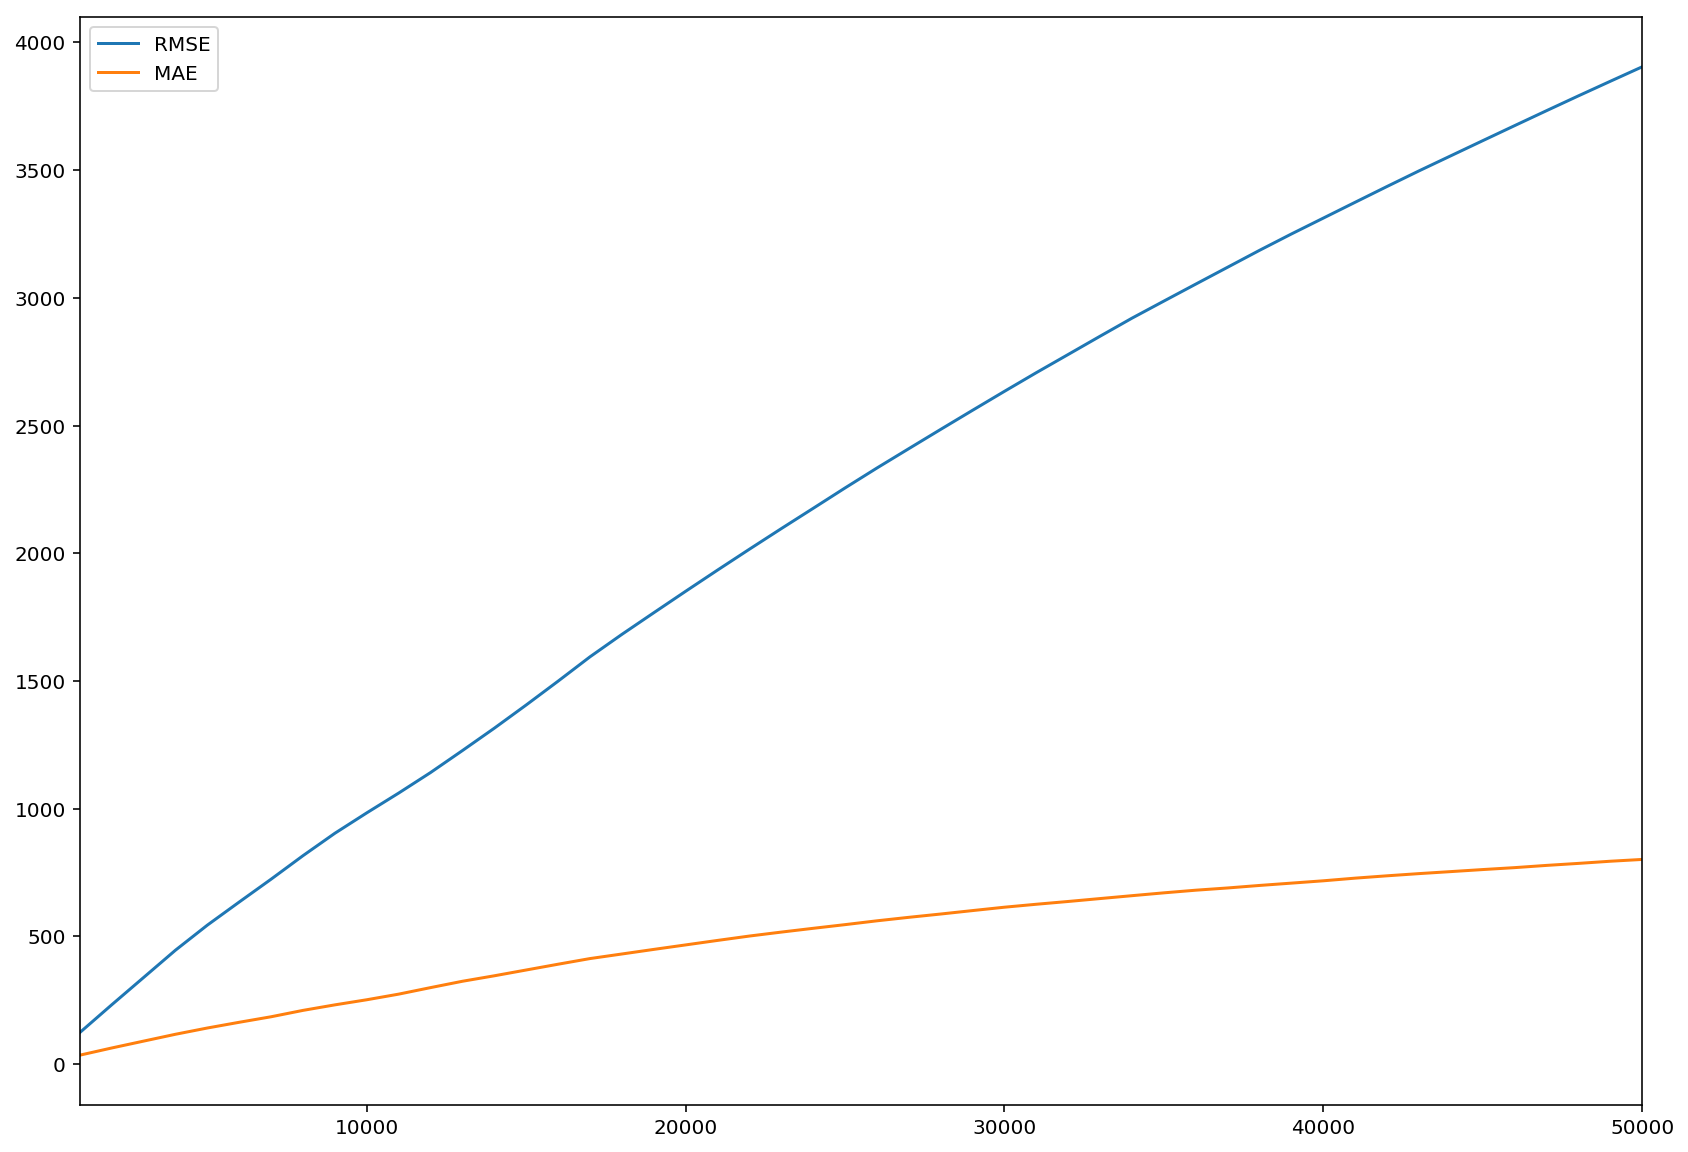

In [36]:
df.plot()

Ошибка до отбора признаков:

In [37]:
train,test=split_data(pact,7,60)
regr=LGBMRegressor(n_estimators=100,seed=123)
regr.fit(train.drop("revenue",axis=1),train.revenue)
mean_squared_error(test.revenue,regr.predict(test.drop("revenue",axis=1)))

8290.0356561985081

In [38]:
train,test=split_data(pact,7,60,extra_features=True)
regr=LGBMRegressor(n_estimators=100,seed=123)
regr.fit(train.drop("revenue",axis=1),train.revenue)
mean_squared_error(test.revenue,regr.predict(test.drop("revenue",axis=1)))

8299.3244466123269